# Sentiment analysis on tweets

The goal of this project is to compare the performance of LSTM and pre-trained BERT under the limited time. When you see performance of an AI model, it often the case that it does not perform as expected for your own problem while it does for the evaluated environment.

The major reasons being
 * time is limited and do not have access to high performance cloud TPUs for optimisation
 * input data is structurally different
 * less number of labeled data are available

Here, I have 1 million sentiment labeled tweets from Stocktwit. The performance is measured in terms of accuracy and f1 score, spending a small and the same amount of time for hyperparameter tuning.

My expectation is
 * Normal LSTM can perform well on tweet type of text, as it usually does not have long complex sentence structures.
 * LSTM will overfit when the training samples are not enough but it can be trained when more inputs are avaiable
 * Pre-trained BERT has been trained Wikipedia+Book Corpus, which is quite different from tweet, thus not performing well while transfer learning is still valid

Let's see.

## Import and configurations

In [5]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

True

In [6]:
# Note: After the following pip install, you may need to restart the kernel.
# Required modules - written here so that it can setup a new instance in Colab. Not required to run every time.
is_first = False

if IN_COLAB or is_first:
    !pip install scikit-plot transformers

     |████████████████████████████████| 1.1MB 10.1MB/s 
     |████████████████████████████████| 3.0MB 30.4MB/s 
     |████████████████████████████████| 1.1MB 31.4MB/s 
     |████████████████████████████████| 890kB 54.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=2efe8d2621b8a10cb8a32dddeccc0c750a3c9db420eb9252e70f99a5992751c0
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [7]:
# Python libraries
import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import os
import sys
import time
import logging
import random
import json
from collections import defaultdict, Counter

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')

# Import Scikit-learn moduels
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold, learning_curve, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
import scikitplot as skplt

# Import nltk modules and download dataset
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [8]:
import torch
# Check GPU Device
if IN_COLAB:
    print(torch.cuda.get_device_name(0))

Tesla T4


In [9]:
# Set logger
loggers = {}

def set_logger(name, level):
    global loggers

    if loggers.get(name):
        return loggers.get(name)
    else:
        logger = logging.getLogger(name)
        if (logger.hasHandlers()):
            logger.handlers.clear()
            
        logger.setLevel(level)

        timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
        formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')

        fh = logging.FileHandler(name + '.log')
        # fh.setLevel(logging.DEBUG)
        fh.setFormatter(formatter)
        logger.addHandler(fh)

        ch = logging.StreamHandler(sys.stdout)
        # ch.setLevel(level)
        ch.setFormatter(formatter)
        logger.addHandler(ch)
        
        loggers[name] = logger
        return logger

logger = set_logger('sa_tweet_inperf', logging.DEBUG)

In [10]:
# Set Random Seed
random.seed(42)
np.random.seed(42)
rand_seed = 42
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [11]:
# Set Seaborn Style
sns.set(style='white', context='notebook', palette='deep')

In [13]:
# Mount Google Drive
# Enter the oauth code from the link
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
# Specify file locations
if IN_COLAB:
    tweet_dir = 'drive/My Drive/Colab Data/'
    output_dir = 'drive/My Drive/Colab Data/'
else:
    tweet_dir = './data/tweet/'
    output_dir = './data/result/'


## Evaluation Config

### Metrics
As the data are imbalanced, use F1 score (micro) in addition to Accuracy. For cross validation, refit to F1 score.

In [15]:
# Define metrics
# Here, use F1 Macro to evaluate the model.
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

## Load Input Data
Tweet data from Stocktwit

In [16]:
def load_tweet(filename):
    ''' Clean FinancialPhrasebank data
        Input:
            - filename
        Output:
            - a dataframe for the loaded financial phase bank data
    '''
    with open(tweet_dir + filename, 'r') as f:
        twits = json.load(f)

    logger.debug(twits['data'][:10])
    logger.info("The number of twits is: {}".format(len(twits['data'])))
    messages = [twit['message_body'] for twit in twits['data']]
    # Since the sentiment scores are discrete, we'll scale the sentiments to 0 to 4 for use in the network
    sentiments = [twit['sentiment'] + 2 for twit in twits['data']]
    
    logger.info("Sample Messages: \n{}".format(messages[:10]))
    return messages, sentiments

In [17]:
# Load data
filename = 'twits.json'
messages, sentiments = load_tweet(filename)

[2020-10-17 05:35:20,056][DEBUG] ## [{'message_body': '$FITB great buy at 26.00...ill wait', 'sentiment': 2, 'timestamp': '2018-07-01T00:00:09Z'}, {'message_body': '@StockTwits $MSFT', 'sentiment': 1, 'timestamp': '2018-07-01T00:00:42Z'}, {'message_body': '#STAAnalystAlert for $TDG : Jefferies Maintains with a rating of Hold setting target price at USD 350.00. Our own verdict is Buy  http://www.stocktargetadvisor.com/toprating', 'sentiment': 2, 'timestamp': '2018-07-01T00:01:24Z'}, {'message_body': '$AMD I heard there’s a guy who knows someone who thinks somebody knows something - on StockTwits.', 'sentiment': 1, 'timestamp': '2018-07-01T00:01:47Z'}, {'message_body': '$AMD reveal yourself!', 'sentiment': 0, 'timestamp': '2018-07-01T00:02:13Z'}, {'message_body': '$AAPL Why the drop? I warren Buffet taking out his position?', 'sentiment': 1, 'timestamp': '2018-07-01T00:03:10Z'}, {'message_body': '$BA bears have 1 reason on 06-29 to pay more attention https://dividendbot.com?s=BA', 'senti

## Process Input text

In [18]:
def preprocess(message):
    """
    This function takes a string as input, then performs these operations: 
        - lowercase
        - remove URLs
        - remove ticker symbols 
        - removes punctuation
        - tokenize by splitting the string on whitespace 
        - removes any single character tokens
    
    Parameters
    ----------
        message : The text message to be preprocessed.
        
    Returns
    -------
        tokens: The preprocessed text into tokens.
    """ 
    # Lowercase the twit message
    text = message.lower()
    
    # Replace URLs with a space in the message
    text = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', text)
    
    # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    text = re.sub('\$[a-zA-Z0-9]*', ' ', text)
    
    # Replace StockTwits usernames with a space. The usernames are any word that starts with @.
    text = re.sub('\@[a-zA-Z0-9]*', ' ', text)

    # Replace everything not a letter or apostrophe with a space
    text = re.sub('[^a-zA-Z\']', ' ', text)
    
    return text

In [19]:
# Check
test_message = "RT @google Our annual looked at the year in Google's blogging (and beyond) http://t.co/sptHOAh8 $GOOG"
print(preprocess(test_message))

rt   our annual looked at the year in google's blogging  and beyond     


In [20]:
# Process for all messages
preprocessed = [preprocess(message) for message in tqdm(messages)]

## Explore the text

In [21]:
all_words = [word for message in preprocessed for word in message.split()]
print('The number of all words: ', len(all_words))

counts = Counter(all_words)
print('The number of unique words: ', len(counts))

bow = sorted(counts, key=counts.get, reverse=True)
print('Top 40 frequent words: ', bow[:40])

The number of all words:  16553561
The number of unique words:  105899
Top 40 frequent words:  ['the', 'to', 'is', 'a', 'for', 'on', 'of', 'and', 'in', 'this', 's', 'i', 'it', 'at', 'will', 'up', 'are', 'you', 'that', 'be', 'q', 'what', 'today', 't', 'here', 'just', 'buy', 'down', 'with', 'short', 'not', 'we', 'from', 'all', 'if', 'now', 'out', 'they', 'more', 'was']


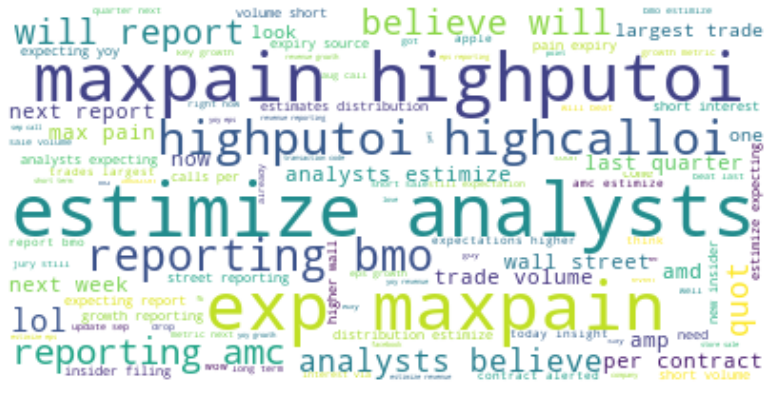

In [22]:
# Generate Word Cloud image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text = " ".join(all_words)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=None, max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize=(15,7))
# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [23]:
preprocessed[:2]

['  great buy at         ill wait', '   ']

In [24]:
tmp_dict = {'org message': messages, 'sentence': preprocessed, 'label': sentiments}
tmp_df = pd.DataFrame(tmp_dict)

# Samples
pd.set_option('display.max_colwidth', -1)
tmp_df.sample(n=20, random_state=rand_seed)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


org message  ... label
1377037  $NFLX there is &#39;sell the news&#39; and there is WTF just happened counter -counter intuitive, non fuggin stop, give it to them on a platter move                                                                                                                                                                 ...  1   
1024181  $GE $NTNX we  have seen this mkt manipulation by hedge funds thru fake news and/or WS lowlife spokesperson like tusa.                                                                                                                                                                                                ...  3   
944591   $CHK Bought in. Like the way this chart is heading towards.                                                                                                                                                                                                                                                          ...  3   
1086704  $NKE can&#39;t make a good quality shoe...so they divert attention to politics..they find out they aren&#39;t good at either...                                                                                                                                                                                      ...  2   
126458   $AMZN big guys got out, bull tards left holding a serious bag of testicles                                                                                                                                                                                                                                           ...  1   
230284   $MU congrats to those who followed my call and shorted this at 55.4 👍🏻                                                                                                                                                                                                                                               ...  0   
830349   $AMZN 1950 puts still looking good for tomorrow, honestly expected a higher push before lower lows                                                                                                                                                                                                                   ...  3   
882668   $AVGO should I be adding here?? Options please                                                                                                                                                                                                                                                                       ...  3   
1059772  $MCD if you don&#39;t buy this you hate America.                                                                                                                                                                                                                                                                     ...  3   
657245   $EXPE&#39;s Room Nights Growth is a key growth metric for their next report on 10/25 AMC. Will they beat last quarter&#39;s 12.0% Room Nights G...\nhttp://www.estimize.com/intro/expe?chart=historical&amp;metric_name=room_nights_growth&amp;utm_content=EXPE&amp;utm_medium=key_metric&amp;utm_source=stocktwits  ...  3   
680524   Based on IEX data, bearish investors have taken some punishment in $TDC. If started 3 months ago, their return is around -5.77% as of 08-24 https://www.shortpainbot.com?s=TDC                                                                                                                                       ...  0   
559578   $LRCX Longs- how does it feel to be a complete failure?                                                                                                                                                                                                                                                              ...  4   
1517801  $BB I agree with the judge on th

In [25]:
# Change the table display config back
pd.set_option('display.max_colwidth', 50)

## Data Selection

In [26]:
# Here, just use all tweets having more than 5 words
# Consider resampling for balancing data if required

train_df = tmp_df.loc[tmp_df['sentence'].apply(lambda x: len(x.split())) > 5]
train_df.reset_index(drop=True, inplace=True)
print("The total number of data: ", len(train_df))

The total number of data:  1134029


In [27]:
# Graph
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,5))
sns.countplot(x='label', data=train_df, ax=ax1)
ax1.set_title('The number of data for each label', fontsize=14)

sns.histplot([len(x) for x in train_df['sentence']], ax=ax2, bins=100)
ax2.set_title('The number of letters in each data', fontsize=14)
ax2.set_xlim(0,200)
ax2.set_xlabel('number of letters')
plt.show()

# LSTM (RNN)
Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work.1 They work tremendously well on a large variety of problems, and are now widely used.

LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

All recurrent neural networks have the form of a chain of repeating modules of neural network. In standard RNNs, this repeating module will have a very simple structure, such as a single tanh layer.

LSTMs also have this chain like structure, but the repeating module has a different structure. Instead of having a single neural network layer, there are four, interacting in a very special way.

<table><tr><td><img src="./docs/lstm_4.png" width=450></td><td><img src="./docs/lstm_1.png" width=300></td></tr></table>


In [143]:
# Import Pytorch modules
# import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam, AdamW

### Tokenise input texts

In [144]:
def tokenize_df(df, col='sentence', lemma=True, stopwords=True, tokenizer='NLTK'):
    '''
    Extract words which are only aphabet and not in stop word, covert to lower case.
    tokenizer: Use NLTK or (alphabet + "'s" + "'t")
    '''
    tokenized = []
    
    for text in tqdm(df[col]):
        # Filter alphabet words only , make it loser case
        if tokenizer=='NLTK':
            words = [word.lower() for word in word_tokenize(text) if (word.isalpha()==1)]
        else:
            words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text.lower())

        # Remove stop words
        if stopwords:
             words = [word for word in words if (word not in stop)]
        # Lemmatize words (first noun, then verb)
        if lemma:
            wnl = nltk.stem.WordNetLemmatizer()
            tokens = [wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v') for word in words]
            tokenized.append(tokens)
        else:
            tokenized.append(words)

    # Concat the list to create docs
    tokenized_text = [" ".join(words) for words in tokenized]

    # Create a list of all the words in the dataframe
    all_words = [word for text in tokenized for word in text]

    # Counter object of all the words
    counts = Counter(all_words)

    # Create a Bag of Word, sorted by the count of words
    bow = sorted(counts, key=counts.get, reverse=True)

    # Indexing vocabrary, starting from 1.
    vocab = {word: ii for ii, word in enumerate(counts, 1)}
    id2vocab = {v: k for k, v in vocab.items()}

    # Create token id list
    token_ids = [[vocab[word] for word in text_words] for text_words in tokenized]

    return tokenized, tokenized_text, bow, vocab, id2vocab, token_ids


In [145]:
# Tokenize
tokenized, tokenized_text, bow, vocab, id2vocab, token_ids = tokenize_df(train_df, col='sentence', lemma=False, stopwords=False, tokenizer='Own')

In [146]:
# Plot
fig = plt.figure(figsize=(10,5))
ax = sns.histplot([len(x) for x in token_ids], bins=100)
ax.set_xlim(0,40)
ax.set_xlabel("The number of words in each text")


Text(0.5, 0, 'The number of words in each text')

In [147]:
X_all = token_ids
y_all = train_df['label']
print("len(X_all): ", len(X_all))
print("len(y_all): ", len(y_all))

len(X_all):  1134029
len(y_all):  1134029


### Define Model
#### Embed -> RNN -> Dense -> Softmax

In [148]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, lstm_size, dense_size, output_size, lstm_layers=2, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.lstm_size = lstm_size
        self.dense_size = dense_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers, dropout=dropout, batch_first=False)
        self.dropout = nn.Dropout(dropout)

        if dense_size == 0:
            self.fc = nn.Linear(lstm_size, output_size)
        else:
            self.fc1 = nn.Linear(lstm_size, dense_size)
            self.fc2 = nn.Linear(dense_size, output_size)

        self.softmax = nn.LogSoftmax(dim=1)

    def init_hidden(self, batch_size):
        """
        Initialize the hidden state
        """
        weight = next(self.parameters()).data
        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
                  weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        
        return hidden

    def forward(self, nn_input_text, hidden_state):
        """
        Perform a forward pass of the model on nn_input
        """
        batch_size = nn_input_text.size(0)
        nn_input_text = nn_input_text.long()
        embeds = self.embedding(nn_input_text)
        lstm_out, hidden_state = self.lstm(embeds, hidden_state)
        # Stack up LSTM outputs, apply dropout
        lstm_out = lstm_out[-1,:,:]
        lstm_out = self.dropout(lstm_out)
        # Dense layer
        if self.dense_size == 0:
            out = self.fc(lstm_out)
        else:
            dense_out = self.fc1(lstm_out)
            out = self.fc2(dense_out)
        # Softmax
        logps = self.softmax(out)

        return logps, hidden_state

### DataLoaders and Batching

Here, I used own dataloader. It's also fine to use tensorflow/keras or pytorch implementation.

In [149]:
def dataloader(messages, labels, sequence_length=200, batch_size=16, shuffle=False):
    """ 
    Build a dataloader.
    """
    if shuffle:
        indices = list(range(len(messages)))
        random.shuffle(indices)
        messages = [messages[idx] for idx in indices]
        labels = [labels[idx] for idx in indices]

    total_sequences = len(messages)

    for ii in range(0, total_sequences, batch_size):
        batch_messages = messages[ii: ii+batch_size]
        
        # First initialize a tensor of all zeros
        batch = torch.zeros((sequence_length, len(batch_messages)), dtype=torch.int64)
        for batch_num, tokens in enumerate(batch_messages):
            token_tensor = torch.tensor(tokens)
            # Left pad!
            start_idx = max(sequence_length - len(token_tensor), 0)
            batch[start_idx:, batch_num] = token_tensor[:sequence_length]
        label_tensor = torch.tensor(labels[ii: ii+len(batch_messages)])
        
        yield batch, label_tensor

In [150]:
# Test the model
text_batch, labels = next(iter(dataloader(X_all, y_all)))
lstm_model = TextClassifier(len(vocab), 512, 128, 8, 3)
hidden = lstm_model.init_hidden(16)
logps, hidden = lstm_model.forward(text_batch, hidden)
print(logps)

tensor([[-1.1688, -1.0998, -1.0319],
        [-1.1788, -1.0547, -1.0670],
        [-1.1620, -1.0817, -1.0552],
        [-1.1852, -1.0697, -1.0464],
        [-1.1813, -1.0586, -1.0608],
        [-1.1826, -1.0556, -1.0627],
        [-1.1593, -1.1073, -1.0333],
        [-1.1904, -1.0635, -1.0479],
        [-1.1740, -1.0932, -1.0336],
        [-1.1799, -1.0636, -1.0571],
        [-1.1807, -1.0843, -1.0362],
        [-1.1725, -1.0743, -1.0531],
        [-1.1781, -1.0711, -1.0513],
        [-1.1753, -1.1054, -1.0211],
        [-1.1776, -1.0695, -1.0532],
        [-1.1793, -1.0754, -1.0460]], grad_fn=<LogSoftmaxBackward>)


### Configure the model and train!

In [163]:
# Define the training process

def train_lstm_model(lstm_model, X_train, y_train, X_valid, y_valid, epochs, batch_size, learning_rate, sequence_length, patience, clip, valid_every, verbose):
    '''
    Train the given LSTM model, using Adam optimizer
    INPUT:
     lstm_model, X_train, y_train, X_valid, y_valid - model and data
     epochs - the number of epochs to loop
     batch_size - batch size, or the number of data processed at one time to optimize
     learning_rate - set in the Adam optimizer
     sequence_length - the number of words per input sentence
     patience - the training stops after no improvement of this times 
     clip - clip the gradient at this number to avoid exploding gradient problem
     valid_every - validation is performed after every this steps
     verbose - 0: only output at the end, 1: output for each epoch, 2: output for all validation cycle
    OUTPUT:
     valid_acc - The accuracy score at the last validation step
     valid_f1 - The F1 score at the last validation step

    '''
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize Model
    lstm_model.embedding.weight.data.uniform_(-1, 1)
    lstm_model.to(device)

    criterion = nn.NLLLoss()
    optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)
    lstm_model.train()

    # Initialise
    accuracy = []
    f1_score = []
    best_f1, early_stop = 0, 0 
    train_losses, valid_losses = [], []
    class_names = ['0:Very Negative','1:Negative', '2:Neutral', '3:Positive', '4:Very Positive']
    
    # Validation steup
    def do_vadalition(valid_hidden):
        lstm_model.eval()
        valid_loss = 0
        y_truth, y_predicted = [], []
        # valid_hidden = lstm_model.init_hidden(batch_size)

        for val_i, (text_batch, labels) in enumerate(
            dataloader(X_valid, y_valid, batch_size=batch_size, sequence_length=sequence_length, shuffle=False)):

            # Skip the last batch of which size is not equal to batch_size
            if text_batch.size(1) != batch_size:
                break

            # Creating new variables for the hidden state
            valid_hidden = tuple([each.data for each in valid_hidden])

            # Set Device
            text_batch, labels = text_batch.to(device), labels.to(device)
            for each in valid_hidden:
                each.to(device)

            # Get output and hidden state from the model
            valid_output, _ = lstm_model(text_batch, valid_hidden)

            # Calculate the loss     
            valid_loss += criterion(valid_output.squeeze(), labels).item()

            # Prediction
            ps = torch.exp(valid_output)
            top_p, top_class = ps.topk(1, dim=1)

            y_predicted.extend(top_class.squeeze().cpu().numpy())
            y_truth.extend(labels.view(*top_class.shape).squeeze().cpu().numpy())

        lstm_model.train()
        valid_loss = valid_loss / val_i

        return y_truth, y_predicted, valid_loss

    # Training cycle
    for epoch in tqdm(range(epochs), desc="Epochs"):
        hidden = lstm_model.init_hidden(batch_size)
        steps = 0
        train_loss, valid_loss = 0, 0

        for train_i, (text_batch, labels) in enumerate(
            dataloader(X_train, y_train, batch_size=batch_size, sequence_length=sequence_length, shuffle=False)):
            steps += 1
            # Skip the last batch of which size is not equal to batch_size
            if text_batch.size(1) != batch_size:
                break

            # Creating new variables for the hidden state to avoid backprop entire training history
            hidden = tuple([each.data for each in hidden])
        
            # Set Device
            text_batch, labels = text_batch.to(device), labels.to(device)
            for each in hidden:
                each.to(device)
        
            # optimizer.zero_grad()
            lstm_model.zero_grad()
        
            # Get output and hidden state from the model
            output, hidden = lstm_model(text_batch, hidden)

            # Calculate the loss and perform backprop
            loss = criterion(output, labels)
            loss.backward()

            # Training Loss
            train_loss += loss.item()
            #train_losses.append(loss.item())

            # Clip the gradient to prevent the exploading gradient problem in RNN/LSTM
            nn.utils.clip_grad_norm_(lstm_model.parameters(), clip)

            # Optimize
            optimizer.step()

            if steps % valid_every == 0:
                y_truth, y_predicted, valid_loss = do_vadalition(hidden)
                valid_acc, valid_f1 = metric(y_truth, y_predicted)
                valid_losses.append(valid_loss)
                accuracy.append(valid_acc)
                f1_score.append(valid_f1)
                train_losses.append(train_loss/valid_every)
                train_loss = 0
                
                if verbose >= 2:
                    logger.info("Epoch: {}/{}, Step: {}, Loss: {:.4f}, Acc: {:.4f}, F1: {:.4f}".format(
                        epoch+1, epochs, steps, valid_loss, valid_acc, valid_f1))

        # End of epoch evaluation
        y_truth, y_predicted, valid_loss = do_vadalition(hidden)
        valid_acc, valid_f1 = metric(y_truth, y_predicted)
        valid_losses.append(valid_loss)
        accuracy.append(valid_acc)
        f1_score.append(valid_f1)
        train_losses.append(train_loss/valid_every)
        train_loss = 0
        
        if verbose >= 1:
            # Plot Confusion Matrix
            y_truth_class = [class_names[int(idx)] for idx in y_truth]
            y_predicted_class = [class_names[int(idx)] for idx in y_predicted]
            
            titles_options = [("Actual Count", None), ("Normalised", 'true')]
            for title, normalize in titles_options:
                disp = skplt.metrics.plot_confusion_matrix(y_truth_class, y_predicted_class, normalize=normalize, title=title, x_tick_rotation=45)
            plt.show()

            logger.info("Epoch: %d, Steps: %d, Accuracy: %.8f, F1: %.8f\n" % (epoch+1, steps, valid_acc, valid_f1))

        # If not improving, count up for early stopping
        if best_f1 < valid_f1:
            early_stop = 0
            best_f1 = valid_f1
        else:
            early_stop += 1
                
        # Early stop if it reaches patience number
        if early_stop >= patience:
            break

    # Post process
    if verbose == 0:
        # Plot Confusion Matrix
        y_truth_class = [class_names[int(idx)] for idx in y_truth]
        y_predicted_class = [class_names[int(idx)] for idx in y_predicted]
        
        titles_options = [("Actual Count", None), ("Normalised", 'true')]
        for title, normalize in titles_options:
            disp = skplt.metrics.plot_confusion_matrix(y_truth_class, y_predicted_class, normalize=normalize, title=title, x_tick_rotation=45)
        plt.show()

    # plot training performance
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
    ax1.set_title("Losses")
    ax1.set_xlabel("Validation Cycle")
    ax1.set_ylabel("Loss")
    ax1.plot(train_losses, 'b-o', label='Train Loss')
    ax1.plot(valid_losses, 'r-o', label='Validation Loss')
    ax1.legend(loc="upper right")
    
    ax2.set_title("Evaluation")
    ax2.set_xlabel("Validation Cycle")
    ax2.set_ylabel("Score")
    ax2.set_ylim(0,1)
    ax2.plot(accuracy, 'y-o', label='Accuracy')
    ax2.plot(f1_score, 'g-o', label='F1 Score')
    ax2.legend(loc="upper right")

    plt.show()
    
    logger.info("##### Completed all epochs #####")
    logger.info("Accuracy: %.8f, F1: %.8f" % (valid_acc, valid_f1))

    return valid_acc, valid_f1

In [42]:
# Set Hyperparameters

# for Training
epochs=5
batch_size=64
learning_rate=3e-4
sequence_length=30
dropout=0.1
patience=3
clip=5
valid_every=100
verbose=2

# Model parameters
embed_size=512
lstm_size=128
dense_size=0
lstm_layers=2

In [43]:
n_trains = [1000, 5000, 10000, 100000, 500000]
result_lstm = pd.DataFrame(columns=['Accuracy', 'F1', 'Time'], index=n_trains)
result_lstm

Accuracy   F1 Time
1000        NaN  NaN  NaN
5000        NaN  NaN  NaN
10000       NaN  NaN  NaN
100000      NaN  NaN  NaN
500000      NaN  NaN  NaN

[2020-10-16 10:16:36,406][INFO] ## Start training for 1000 samples


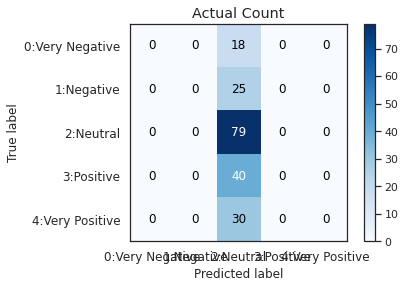

[2020-10-16 10:16:38,945][INFO] ## Epoch: 1, Steps: 16, Accuracy: 0.41145833, F1: 0.11660517



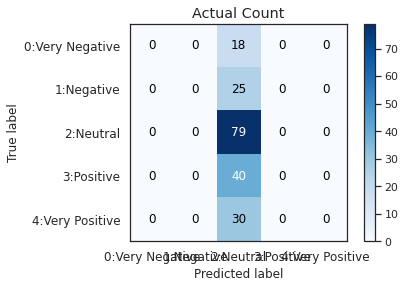

[2020-10-16 10:16:39,778][INFO] ## Epoch: 2, Steps: 16, Accuracy: 0.41145833, F1: 0.11660517



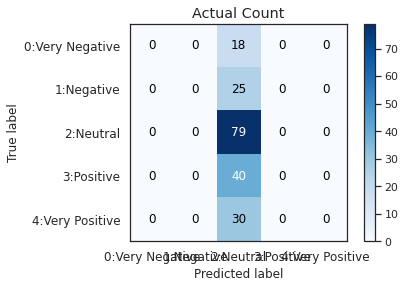

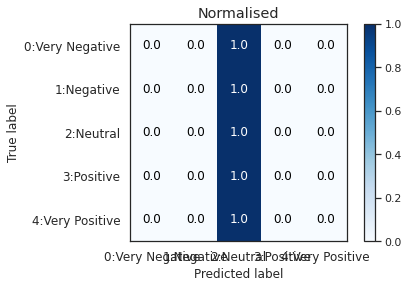

[2020-10-16 10:16:40,570][INFO] ## Epoch: 3, Steps: 16, Accuracy: 0.41145833, F1: 0.11660517



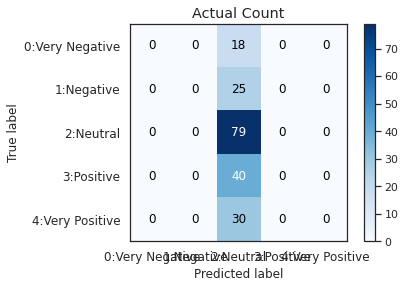

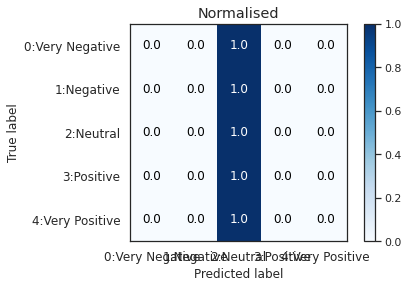

[2020-10-16 10:16:41,357][INFO] ## Epoch: 4, Steps: 16, Accuracy: 0.41145833, F1: 0.11660517



[2020-10-16 10:16:41,825][INFO] ## ##### Completed all epochs #####
[2020-10-16 10:16:41,827][INFO] ## Accuracy: 0.41145833, F1: 0.11660517
[2020-10-16 10:16:41,829][INFO] ## Process Time (sec): 4.021310719000212
[2020-10-16 10:16:41,837][INFO] ## Start training for 5000 samples


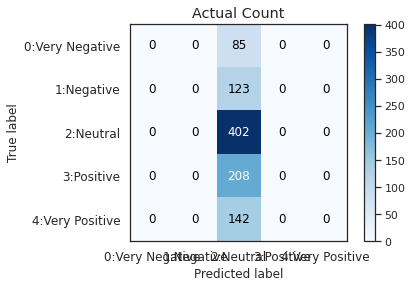

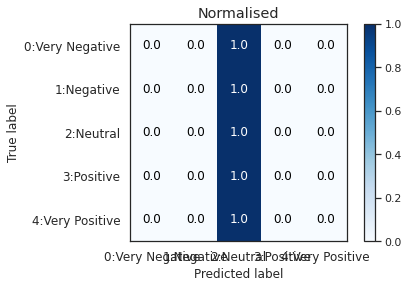

[2020-10-16 10:16:46,098][INFO] ## Epoch: 1, Steps: 79, Accuracy: 0.41875000, F1: 0.11806167



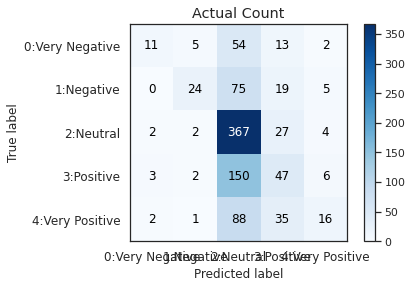

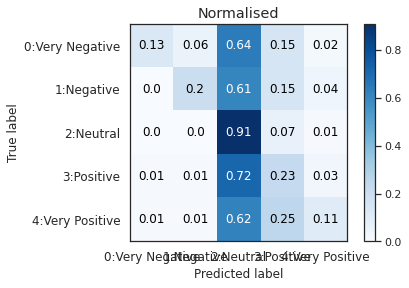

[2020-10-16 10:16:48,524][INFO] ## Epoch: 2, Steps: 79, Accuracy: 0.48437500, F1: 0.32352992



[2020-10-16 10:16:51,017][INFO] ## Epoch: 3, Steps: 79, Accuracy: 0.50729167, F1: 0.39813254



[2020-10-16 10:16:53,487][INFO] ## Epoch: 4, Steps: 79, Accuracy: 0.51145833, F1: 0.45053563



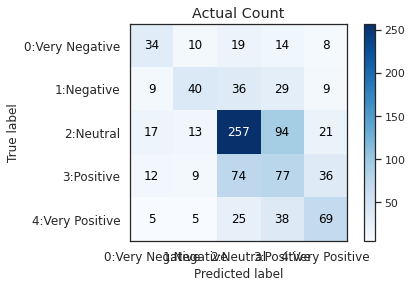

[2020-10-16 10:16:55,939][INFO] ## Epoch: 5, Steps: 79, Accuracy: 0.49687500, F1: 0.45419451




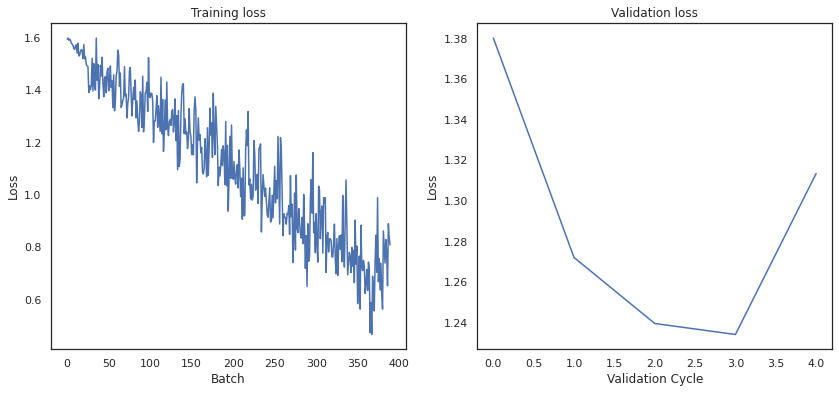

[2020-10-16 10:16:56,387][INFO] ## ##### Completed all epochs #####
[2020-10-16 10:16:56,395][INFO] ## Accuracy: 0.49687500, F1: 0.45419451
[2020-10-16 10:16:56,397][INFO] ## Process Time (sec): 13.188963326999328
[2020-10-16 10:16:56,400][INFO] ## Start training for 10000 samples


100
100
[2020-10-16 10:17:00,810][INFO] ## Epoch: 1/5, Step: 100, Loss: 1.3679, Acc: 0.4279, F1: 0.1254


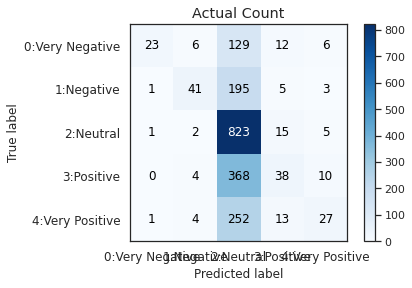

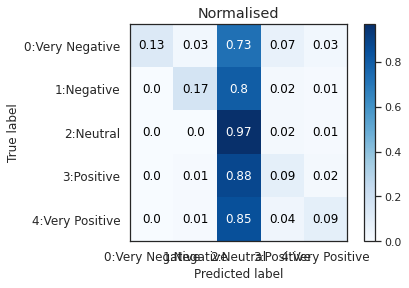

[2020-10-16 10:17:02,748][INFO] ## Epoch: 1, Steps: 157, Accuracy: 0.47983871, F1: 0.28708782

100
100
[2020-10-16 10:17:05,406][INFO] ## Epoch: 2/5, Step: 100, Loss: 1.1894, Acc: 0.5232, F1: 0.4124


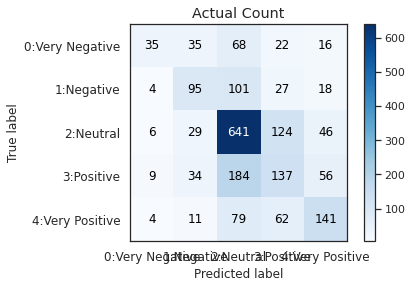

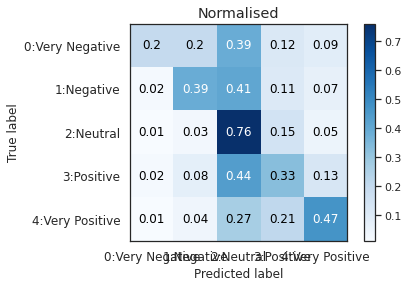

[2020-10-16 10:17:07,339][INFO] ## Epoch: 2, Steps: 157, Accuracy: 0.52872984, F1: 0.44552259

100
100
[2020-10-16 10:17:09,997][INFO] ## Epoch: 3/5, Step: 100, Loss: 1.1262, Acc: 0.5474, F1: 0.4789


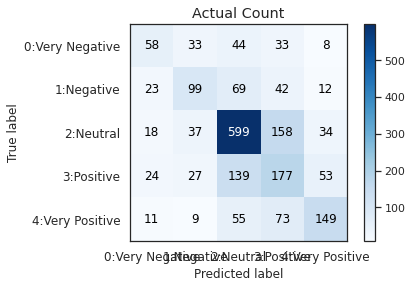

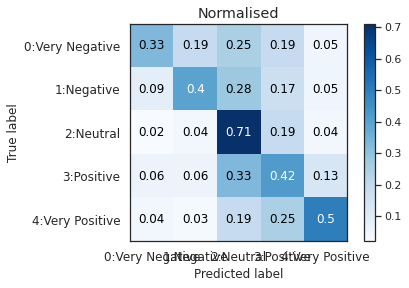

[2020-10-16 10:17:11,922][INFO] ## Epoch: 3, Steps: 157, Accuracy: 0.54536290, F1: 0.48577778

100
100
[2020-10-16 10:17:14,560][INFO] ## Epoch: 4/5, Step: 100, Loss: 1.1422, Acc: 0.5494, F1: 0.5003


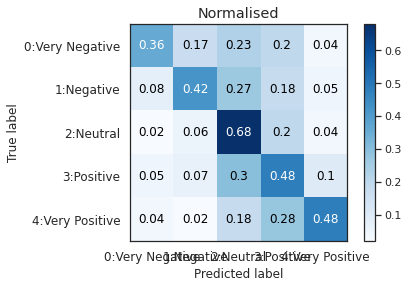

[2020-10-16 10:17:16,532][INFO] ## Epoch: 4, Steps: 157, Accuracy: 0.54788306, F1: 0.49771453

100
100
[2020-10-16 10:17:19,223][INFO] ## Epoch: 5/5, Step: 100, Loss: 1.2247, Acc: 0.5413, F1: 0.5046


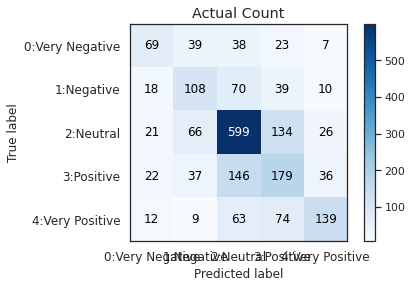

[2020-10-16 10:17:21,177][INFO] ## Epoch: 5, Steps: 157, Accuracy: 0.55141129, F1: 0.49884330




[2020-10-16 10:17:21,659][INFO] ## ##### Completed all epochs #####
[2020-10-16 10:17:21,669][INFO] ## Accuracy: 0.55141129, F1: 0.49884330
[2020-10-16 10:17:21,672][INFO] ## Process Time (sec): 23.884455484999307
[2020-10-16 10:17:21,675][INFO] ## Start training for 100000 samples


100
100
[2020-10-16 10:17:26,857][INFO] ## Epoch: 1/5, Step: 100, Loss: 1.3762, Acc: 0.4287, F1: 0.1332
200
100
[2020-10-16 10:17:30,224][INFO] ## Epoch: 1/5, Step: 200, Loss: 1.2339, Acc: 0.5053, F1: 0.3488
300
100
[2020-10-16 10:17:33,738][INFO] ## Epoch: 1/5, Step: 300, Loss: 1.1485, Acc: 0.5461, F1: 0.4539
400
100
[2020-10-16 10:17:37,100][INFO] ## Epoch: 1/5, Step: 400, Loss: 1.0999, Acc: 0.5640, F1: 0.4671
500
100
[2020-10-16 10:17:40,570][INFO] ## Epoch: 1/5, Step: 500, Loss: 1.0497, Acc: 0.5872, F1: 0.5181
600
100
[2020-10-16 10:17:43,969][INFO] ## Epoch: 1/5, Step: 600, Loss: 1.0269, Acc: 0.5972, F1: 0.5232
700
100
[2020-10-16 10:17:47,343][INFO] ## Epoch: 1/5, Step: 700, Loss: 1.0031, Acc: 0.6041, F1: 0.5311
800
100
[2020-10-16 10:17:50,704][INFO] ## Epoch: 1/5, Step: 800, Loss: 0.9850, Acc: 0.6129, F1: 0.5459
900
100
[2020-10-16 10:17:54,059][INFO] ## Epoch: 1/5, Step: 900, Loss: 0.9675, Acc: 0.6162, F1: 0.5500
1000
100
[2020-10-16 10:17:57,420][INFO] ## Epoch: 1/5, Step: 10

[2020-10-16 10:18:17,407][INFO] ## Epoch: 1, Steps: 1563, Accuracy: 0.64693510, F1: 0.59418682

100
100
[2020-10-16 10:18:20,818][INFO] ## Epoch: 2/5, Step: 100, Loss: 0.8989, Acc: 0.6463, F1: 0.5897
200
100
[2020-10-16 10:18:24,230][INFO] ## Epoch: 2/5, Step: 200, Loss: 0.8846, Acc: 0.6531, F1: 0.6024
300
100
[2020-10-16 10:18:27,726][INFO] ## Epoch: 2/5, Step: 300, Loss: 0.8762, Acc: 0.6557, F1: 0.6046
400
100
[2020-10-16 10:18:31,104][INFO] ## Epoch: 2/5, Step: 400, Loss: 0.8830, Acc: 0.6569, F1: 0.6075
500
100
[2020-10-16 10:18:34,515][INFO] ## Epoch: 2/5, Step: 500, Loss: 0.8657, Acc: 0.6610, F1: 0.6164
600
100
[2020-10-16 10:18:37,870][INFO] ## Epoch: 2/5, Step: 600, Loss: 0.8623, Acc: 0.6613, F1: 0.6146
700
100
[2020-10-16 10:18:41,452][INFO] ## Epoch: 2/5, Step: 700, Loss: 0.8738, Acc: 0.6637, F1: 0.6144
800
100
[2020-10-16 10:18:44,858][INFO] ## Epoch: 2/5, Step: 800, Loss: 0.8683, Acc: 0.6587, F1: 0.6180
900
100
[2020-10-16 10:18:48,299][INFO] ## Epoch: 2/5, Step: 900, Loss: 

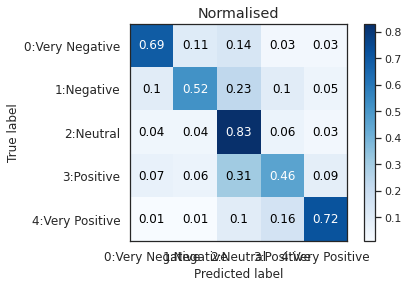

[2020-10-16 10:19:11,864][INFO] ## Epoch: 2, Steps: 1563, Accuracy: 0.68314303, F1: 0.64257268

100
100
[2020-10-16 10:19:15,251][INFO] ## Epoch: 3/5, Step: 100, Loss: 0.8265, Acc: 0.6815, F1: 0.6400
200
100
[2020-10-16 10:19:18,670][INFO] ## Epoch: 3/5, Step: 200, Loss: 0.8212, Acc: 0.6804, F1: 0.6418
300
100
[2020-10-16 10:19:22,025][INFO] ## Epoch: 3/5, Step: 300, Loss: 0.8316, Acc: 0.6846, F1: 0.6471
400
100
[2020-10-16 10:19:25,382][INFO] ## Epoch: 3/5, Step: 400, Loss: 0.8451, Acc: 0.6833, F1: 0.6444
500
100
[2020-10-16 10:19:28,942][INFO] ## Epoch: 3/5, Step: 500, Loss: 0.8268, Acc: 0.6811, F1: 0.6494
600
100
[2020-10-16 10:19:32,429][INFO] ## Epoch: 3/5, Step: 600, Loss: 0.8130, Acc: 0.6861, F1: 0.6514
700
100
[2020-10-16 10:19:35,970][INFO] ## Epoch: 3/5, Step: 700, Loss: 0.8335, Acc: 0.6888, F1: 0.6512
800
100
[2020-10-16 10:19:39,371][INFO] ## Epoch: 3/5, Step: 800, Loss: 0.8256, Acc: 0.6783, F1: 0.6467
900
100
[2020-10-16 10:19:42,766][INFO] ## Epoch: 3/5, Step: 900, Loss: 

[2020-10-16 10:20:06,509][INFO] ## Epoch: 3, Steps: 1563, Accuracy: 0.68815104, F1: 0.65241334

100
100
[2020-10-16 10:20:09,886][INFO] ## Epoch: 4/5, Step: 100, Loss: 0.8100, Acc: 0.6924, F1: 0.6588
200
100
[2020-10-16 10:20:13,241][INFO] ## Epoch: 4/5, Step: 200, Loss: 0.8116, Acc: 0.6879, F1: 0.6535
300
100
[2020-10-16 10:20:16,590][INFO] ## Epoch: 4/5, Step: 300, Loss: 0.8295, Acc: 0.6902, F1: 0.6598
400
100
[2020-10-16 10:20:19,949][INFO] ## Epoch: 4/5, Step: 400, Loss: 0.8580, Acc: 0.6887, F1: 0.6559
500
100
[2020-10-16 10:20:23,430][INFO] ## Epoch: 4/5, Step: 500, Loss: 0.8358, Acc: 0.6846, F1: 0.6573
600
100
[2020-10-16 10:20:26,821][INFO] ## Epoch: 4/5, Step: 600, Loss: 0.8214, Acc: 0.6924, F1: 0.6590
700
100
[2020-10-16 10:20:30,201][INFO] ## Epoch: 4/5, Step: 700, Loss: 0.8475, Acc: 0.6930, F1: 0.6597
800
100
[2020-10-16 10:20:33,737][INFO] ## Epoch: 4/5, Step: 800, Loss: 0.8333, Acc: 0.6808, F1: 0.6516
900
100
[2020-10-16 10:20:37,192][INFO] ## Epoch: 4/5, Step: 900, Loss: 

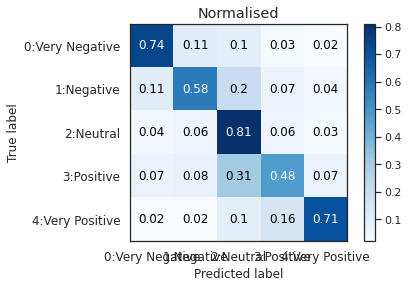

[2020-10-16 10:21:01,025][INFO] ## Epoch: 4, Steps: 1563, Accuracy: 0.68945312, F1: 0.65636743

100
100
[2020-10-16 10:21:04,459][INFO] ## Epoch: 5/5, Step: 100, Loss: 0.8379, Acc: 0.6935, F1: 0.6629
200
100
[2020-10-16 10:21:07,819][INFO] ## Epoch: 5/5, Step: 200, Loss: 0.8414, Acc: 0.6879, F1: 0.6560
300
100
[2020-10-16 10:21:11,347][INFO] ## Epoch: 5/5, Step: 300, Loss: 0.8765, Acc: 0.6853, F1: 0.6601
400
100
[2020-10-16 10:21:14,794][INFO] ## Epoch: 5/5, Step: 400, Loss: 0.9044, Acc: 0.6878, F1: 0.6579
500
100
[2020-10-16 10:21:18,203][INFO] ## Epoch: 5/5, Step: 500, Loss: 0.8794, Acc: 0.6814, F1: 0.6551
600
100
[2020-10-16 10:21:21,677][INFO] ## Epoch: 5/5, Step: 600, Loss: 0.8664, Acc: 0.6893, F1: 0.6570
700
100
[2020-10-16 10:21:25,030][INFO] ## Epoch: 5/5, Step: 700, Loss: 0.8784, Acc: 0.6898, F1: 0.6595
800
100
[2020-10-16 10:21:28,524][INFO] ## Epoch: 5/5, Step: 800, Loss: 0.8906, Acc: 0.6786, F1: 0.6499
900
100
[2020-10-16 10:21:32,120][INFO] ## Epoch: 5/5, Step: 900, Loss: 

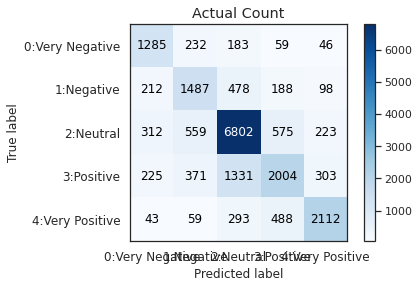

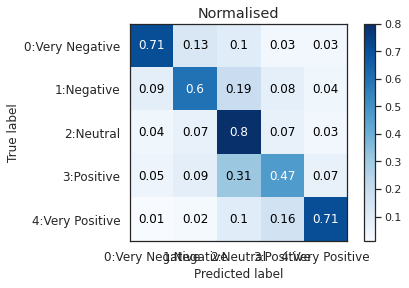

[2020-10-16 10:21:55,738][INFO] ## Epoch: 5, Steps: 1563, Accuracy: 0.68559696, F1: 0.65482817




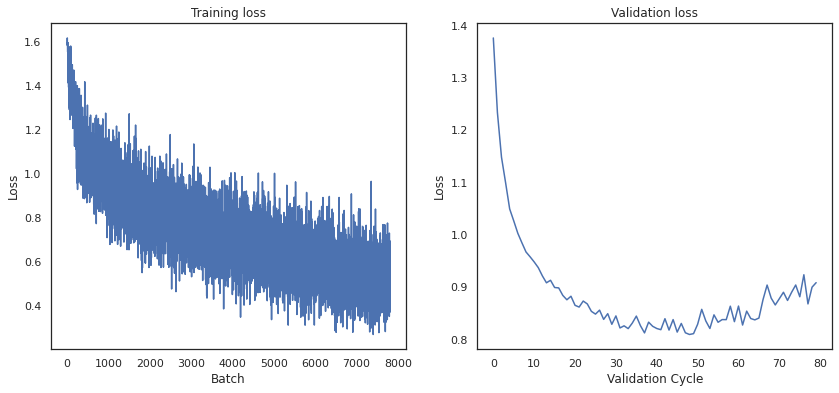

[2020-10-16 10:21:56,213][INFO] ## ##### Completed all epochs #####
[2020-10-16 10:21:56,216][INFO] ## Accuracy: 0.68559696, F1: 0.65482817
[2020-10-16 10:21:56,225][INFO] ## Process Time (sec): 273.11350912500075
[2020-10-16 10:21:56,227][INFO] ## Start training for 500000 samples


100
100
[2020-10-16 10:22:05,063][INFO] ## Epoch: 1/5, Step: 100, Loss: 1.3638, Acc: 0.4286, F1: 0.1369
200
100
[2020-10-16 10:22:11,940][INFO] ## Epoch: 1/5, Step: 200, Loss: 1.2492, Acc: 0.4976, F1: 0.3411
300
100
[2020-10-16 10:22:18,754][INFO] ## Epoch: 1/5, Step: 300, Loss: 1.1511, Acc: 0.5392, F1: 0.4298
400
100
[2020-10-16 10:22:25,648][INFO] ## Epoch: 1/5, Step: 400, Loss: 1.1181, Acc: 0.5592, F1: 0.4923
500
100
[2020-10-16 10:22:32,272][INFO] ## Epoch: 1/5, Step: 500, Loss: 1.0558, Acc: 0.5816, F1: 0.5067
600
100
[2020-10-16 10:22:38,900][INFO] ## Epoch: 1/5, Step: 600, Loss: 1.0450, Acc: 0.5866, F1: 0.5061
700
100
[2020-10-16 10:22:45,440][INFO] ## Epoch: 1/5, Step: 700, Loss: 1.0046, Acc: 0.6010, F1: 0.5338
800
100
[2020-10-16 10:22:52,312][INFO] ## Epoch: 1/5, Step: 800, Loss: 0.9879, Acc: 0.6087, F1: 0.5368
900
100
[2020-10-16 10:22:58,810][INFO] ## Epoch: 1/5, Step: 900, Loss: 0.9680, Acc: 0.6158, F1: 0.5448
1000
100
[2020-10-16 10:23:05,466][INFO] ## Epoch: 1/5, Step: 10

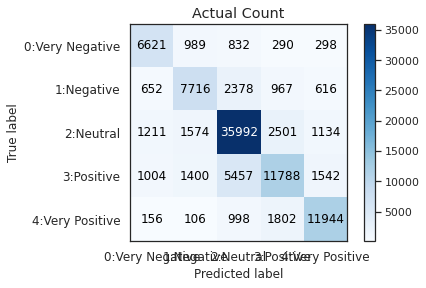

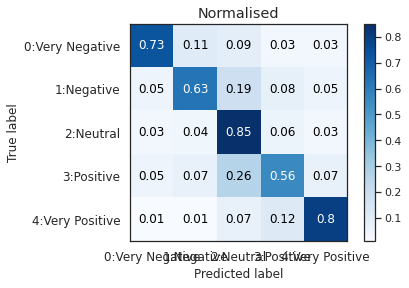

[2020-10-16 10:30:53,432][INFO] ## Epoch: 1, Steps: 7813, Accuracy: 0.74084707, F1: 0.71207296

100
100
[2020-10-16 10:31:00,401][INFO] ## Epoch: 2/5, Step: 100, Loss: 0.6977, Acc: 0.7390, F1: 0.7098
200
100
[2020-10-16 10:31:07,135][INFO] ## Epoch: 2/5, Step: 200, Loss: 0.6935, Acc: 0.7426, F1: 0.7129
300
100
[2020-10-16 10:31:14,284][INFO] ## Epoch: 2/5, Step: 300, Loss: 0.6923, Acc: 0.7435, F1: 0.7147
400
100
[2020-10-16 10:31:21,381][INFO] ## Epoch: 2/5, Step: 400, Loss: 0.6921, Acc: 0.7426, F1: 0.7127
500
100
[2020-10-16 10:31:28,311][INFO] ## Epoch: 2/5, Step: 500, Loss: 0.6909, Acc: 0.7427, F1: 0.7130
600
100
[2020-10-16 10:31:34,923][INFO] ## Epoch: 2/5, Step: 600, Loss: 0.6873, Acc: 0.7425, F1: 0.7115
700
100
[2020-10-16 10:31:41,627][INFO] ## Epoch: 2/5, Step: 700, Loss: 0.6906, Acc: 0.7420, F1: 0.7120
800
100
[2020-10-16 10:31:48,662][INFO] ## Epoch: 2/5, Step: 800, Loss: 0.6937, Acc: 0.7397, F1: 0.7101
900
100
[2020-10-16 10:31:55,326][INFO] ## Epoch: 2/5, Step: 900, Loss: 

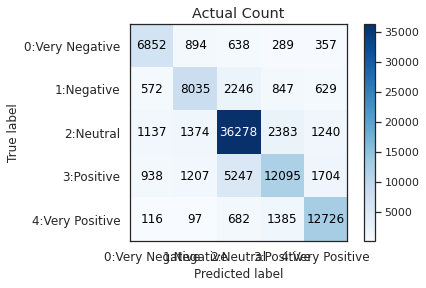

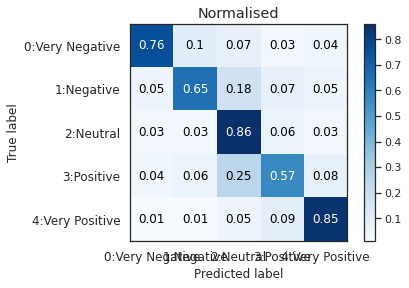

[2020-10-16 10:39:56,623][INFO] ## Epoch: 2, Steps: 7813, Accuracy: 0.76010323, F1: 0.73456607

100
100
[2020-10-16 10:40:03,380][INFO] ## Epoch: 3/5, Step: 100, Loss: 0.6485, Acc: 0.7603, F1: 0.7350
200
100
[2020-10-16 10:40:10,341][INFO] ## Epoch: 3/5, Step: 200, Loss: 0.6466, Acc: 0.7616, F1: 0.7357
300
100
[2020-10-16 10:40:16,981][INFO] ## Epoch: 3/5, Step: 300, Loss: 0.6465, Acc: 0.7620, F1: 0.7353
400
100
[2020-10-16 10:40:23,977][INFO] ## Epoch: 3/5, Step: 400, Loss: 0.6446, Acc: 0.7607, F1: 0.7349
500
100
[2020-10-16 10:40:30,682][INFO] ## Epoch: 3/5, Step: 500, Loss: 0.6506, Acc: 0.7599, F1: 0.7353
600
100
[2020-10-16 10:40:37,468][INFO] ## Epoch: 3/5, Step: 600, Loss: 0.6443, Acc: 0.7618, F1: 0.7359
700
100
[2020-10-16 10:40:44,178][INFO] ## Epoch: 3/5, Step: 700, Loss: 0.6471, Acc: 0.7615, F1: 0.7365
800
100
[2020-10-16 10:40:51,075][INFO] ## Epoch: 3/5, Step: 800, Loss: 0.6507, Acc: 0.7586, F1: 0.7333
900
100
[2020-10-16 10:40:57,672][INFO] ## Epoch: 3/5, Step: 900, Loss: 

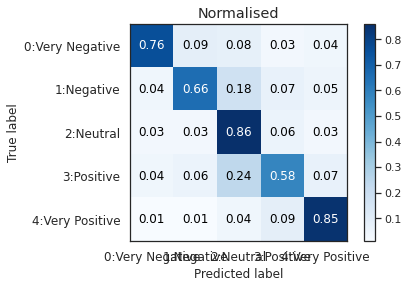

[2020-10-16 10:48:50,990][INFO] ## Epoch: 3, Steps: 7813, Accuracy: 0.76519486, F1: 0.74151935

100
100
[2020-10-16 10:48:57,978][INFO] ## Epoch: 4/5, Step: 100, Loss: 0.6442, Acc: 0.7648, F1: 0.7424
200
100
[2020-10-16 10:49:05,021][INFO] ## Epoch: 4/5, Step: 200, Loss: 0.6445, Acc: 0.7654, F1: 0.7423
300
100
[2020-10-16 10:49:11,867][INFO] ## Epoch: 4/5, Step: 300, Loss: 0.6451, Acc: 0.7666, F1: 0.7425
400
100
[2020-10-16 10:49:18,892][INFO] ## Epoch: 4/5, Step: 400, Loss: 0.6385, Acc: 0.7663, F1: 0.7417
500
100
[2020-10-16 10:49:26,022][INFO] ## Epoch: 4/5, Step: 500, Loss: 0.6470, Acc: 0.7647, F1: 0.7423
600
100
[2020-10-16 10:49:33,306][INFO] ## Epoch: 4/5, Step: 600, Loss: 0.6389, Acc: 0.7657, F1: 0.7412
700
100
[2020-10-16 10:49:40,648][INFO] ## Epoch: 4/5, Step: 700, Loss: 0.6455, Acc: 0.7646, F1: 0.7420
800
100
[2020-10-16 10:49:47,420][INFO] ## Epoch: 4/5, Step: 800, Loss: 0.6495, Acc: 0.7623, F1: 0.7394
900
100
[2020-10-16 10:49:54,456][INFO] ## Epoch: 4/5, Step: 900, Loss: 

[2020-10-16 10:58:04,074][INFO] ## Epoch: 4, Steps: 7813, Accuracy: 0.76372439, F1: 0.74111320

100
100
[2020-10-16 10:58:11,056][INFO] ## Epoch: 5/5, Step: 100, Loss: 0.6619, Acc: 0.7607, F1: 0.7397
200
100
[2020-10-16 10:58:18,081][INFO] ## Epoch: 5/5, Step: 200, Loss: 0.6659, Acc: 0.7597, F1: 0.7388
300
100
[2020-10-16 10:58:24,972][INFO] ## Epoch: 5/5, Step: 300, Loss: 0.6622, Acc: 0.7649, F1: 0.7417
400
100
[2020-10-16 10:58:32,021][INFO] ## Epoch: 5/5, Step: 400, Loss: 0.6570, Acc: 0.7644, F1: 0.7415
500
100
[2020-10-16 10:58:38,806][INFO] ## Epoch: 5/5, Step: 500, Loss: 0.6657, Acc: 0.7610, F1: 0.7397
600
100
[2020-10-16 10:58:45,689][INFO] ## Epoch: 5/5, Step: 600, Loss: 0.6557, Acc: 0.7622, F1: 0.7389
700
100
[2020-10-16 10:58:52,488][INFO] ## Epoch: 5/5, Step: 700, Loss: 0.6696, Acc: 0.7597, F1: 0.7385
800
100
[2020-10-16 10:58:59,424][INFO] ## Epoch: 5/5, Step: 800, Loss: 0.6711, Acc: 0.7589, F1: 0.7372
900
100
[2020-10-16 10:59:06,176][INFO] ## Epoch: 5/5, Step: 900, Loss: 

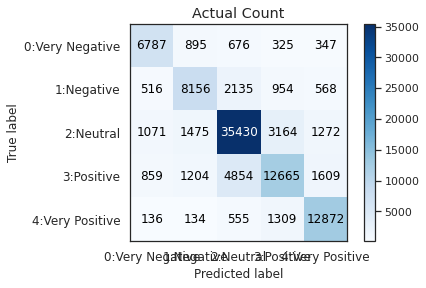

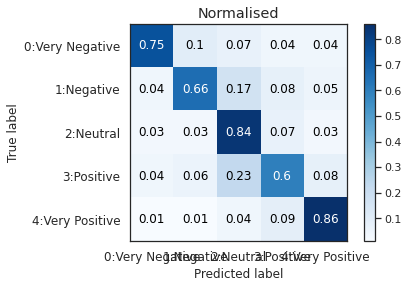

[2020-10-16 11:07:01,753][INFO] ## Epoch: 5, Steps: 7813, Accuracy: 0.75934299, F1: 0.73753189




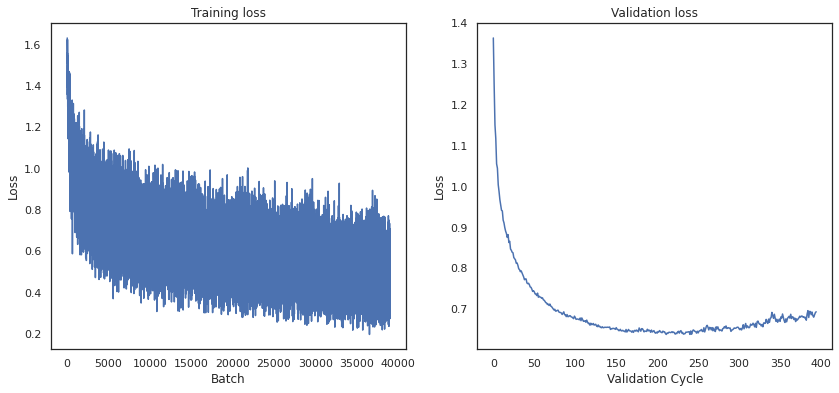

[2020-10-16 11:07:02,287][INFO] ## ##### Completed all epochs #####
[2020-10-16 11:07:02,292][INFO] ## Accuracy: 0.75934299, F1: 0.73753189
[2020-10-16 11:07:02,310][INFO] ## Process Time (sec): 2704.454223975001


Accuracy      F1     Time
1000     0.4115  0.1166  4.02131
5000     0.4969  0.4542   13.189
10000    0.5514  0.4988  23.8845
100000   0.6856  0.6548  273.114
500000   0.7593  0.7375  2704.45

In [44]:
for n in n_trains:
    logger.info("Start training for %d samples" %n)

    # Stratified sampling
    train_size = n / len(X_all)
    test_size = train_size * 0.2    
    sss = StratifiedShuffleSplit(n_splits=1, train_size=train_size, test_size=test_size, random_state=rand_seed)
    for train_indices, test_indices in sss.split(X_all, y_all):
        # Filter 
        X_sampled_train = np.array(X_all, dtype=object)[train_indices]
        y_sampled_train = np.array(y_all)[train_indices]
        X_sampled_test = np.array(X_all, dtype=object)[test_indices]
        y_sampled_test = np.array(y_all)[test_indices]

        # Set Model
        model = TextClassifier(len(vocab)+1, embed_size, lstm_size, dense_size, 5, lstm_layers, dropout)


        # Train the model for this fold
        start_time = time.perf_counter() # use time.process_time() for CPU time
        acc, f1 = train_lstm_model(model, X_sampled_train, y_sampled_train, X_sampled_test, y_sampled_test, \
                                epochs, batch_size, learning_rate, sequence_length, \
                                patience, clip, valid_every, verbose)
        end_time = time.perf_counter() # use time.process_time() for CPU time
        duration = end_time - start_time
        logger.info("Process Time (sec): {}".format(duration))
        result_lstm.loc[n] = (round(acc,4), round(f1,4), duration)
        
result_lstm

# BERT Model

<table><tr><td><img src="./docs/bert_model.png" width=400></td><td><img src="./docs/transformer.png" width=550></td></tr></table>

![Comparison](./docs/bert-vs-openai-vs-elmo.png)

### BERT Encoding

In [23]:
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
#from transformers import *
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
from transformers import AdamW as AdamW_HF, get_linear_schedule_with_warmup

In [24]:
# Use pretrained model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [25]:
X_all = train_df['sentence']
y_all = train_df['label']
print("len(X_all): ", len(X_all))
print("len(y_all): ", len(y_all))

len(X_all):  1134029
len(y_all):  1134029


In [26]:
# Define a DataSet Class which simply return (x, y) pair instead
class SimpleDataset(Dataset):
    def __init__(self, x, y):
        self.datalist=[(x[i], y[i]) for i in range(len(y))]
    def __len__(self):
        return len(self.datalist)
    def __getitem__(self,idx):
        return(self.datalist[idx])

In [27]:
# Test the model and tokenizer
inputs = tokenizer("Hello, my dog is cute", 
                   return_tensors="pt", 
                   pad_to_max_length=True, 
                   max_length = 64,
                   add_special_tokens=True,
                   padding_side='right')
print('inputs: \n', inputs)
print('\ndecoded: \n',tokenizer.decode(inputs['input_ids'].squeeze(0)))

labels = torch.tensor([1]).unsqueeze(0)
print('\nlabels: ', labels)

outputs = bert_model(**inputs, labels=labels)
print('\noutputs: length=', len(outputs))
print(outputs)

loss = outputs[0]
logits = outputs[1]

print('loss: ', loss.detach())
print('logits: ', logits.detach())

print(len(outputs))
print('outputs: \n',outputs)
print('outputs(detached): \n', outputs[0].detach())


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1773: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Keyword arguments {'padding_side': 'right'} not recognized.


inputs: 
 {'input_ids': tensor([[  101,  7592,  1010,  2026,  3899,  2003, 10140,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### Train

In [28]:
def train_transformer(model, x_train, y_train, x_valid, y_valid, learning_rate, num_epochs, batch_size, patience, warm_up_proportion, max_grad_norm, max_seq_length):
    '''
    Train the given BERT model.
    INPUT:
     model, x_train, y_train, x_valid, y_valid - model and data
     learning_rate - set in the AdamW Optimizer, updated with a linear scheduler
     num_epochs - the number of epochs loop
     batch_size - batch size
     patience - training stops after no improvement of this times of epochs
     warm_up_proportion - the initial warmup to reach the designated learning rate
     max_grad_norm - Gradient clipping
     max_seq_length - the number of words per input sentence

    OUTPUT:
     acc - The accuracy score at the last validation cycle
     f1 - The f1 score at the last validation cycle
     valid_best - Prediction from the best validation cycle
     model - The trained model
    '''
    # Move model to GUP/CPU device
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    
    # Load data into SimpleDataset
    train_ds = SimpleDataset(x_train, y_train)
    valid_ds = SimpleDataset(x_valid, y_valid)
    
    # Use DataLoader to load data from Dataset in batches
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
    
    num_total_opt_steps = int(len(train_loader) * num_epochs)
    logger.info('Total Training Steps: {} ({} batches x {} epochs)'.format(num_total_opt_steps, len(train_loader), num_epochs))
    
    # Instead of AdamW from torch.optim, use the one from Huggingface with scheduler for learning curve decay
    # To reproduce BertAdam specific behavior set correct_bias=False
    optimizer = AdamW_HF(model.parameters(), lr=learning_rate, correct_bias=False) 
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_total_opt_steps*warm_up_proportion, num_training_steps=num_total_opt_steps)  # PyTorch scheduler

    # Set Train Mode
    model.train()
    
    # Tokenizer Parameter
    param_tk = {
        'return_tensors': "pt",
        'padding': 'max_length',
        'max_length': max_seq_length,
        'add_special_tokens': True,
        'truncation': True
    }

    # Initialize
    best_f1 = 0.
    early_stop = 0
    train_losses = []
    valid_losses = []
    total_steps = 0
    train_loss_set = []
    
    for epoch in tqdm(range(num_epochs), desc="Epoch"):
        # print('================     epoch {}     ==============='.format(epoch+1))
        train_loss = 0.

        for i, batch in enumerate(train_loader):
            # Input features and labels from batch and move to device
            x_train_bt, y_train_bt = batch
            x_train_bt = tokenizer(x_train_bt, **param_tk).to(device)
            y_train_bt = torch.tensor(y_train_bt, dtype=torch.long).to(device)
            
            # Reset gradient
            optimizer.zero_grad()

            # Feedforward prediction
            loss, logits = model(**x_train_bt, labels=y_train_bt)

            # Backward Propagation
            loss.backward()

            # Training Loss
            train_loss += loss.item() / len(train_loader)
            train_loss_set.append(loss.item())

            # Gradient clipping is not in AdamW anymore (so you can use amp without issue)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            # Update Weights and Learning Rate
            optimizer.step()
            scheduler.step()
            
            logger.debug('train batch: %d, train_loss: %8f' % (i, loss.item() / len(train_loader)))
            total_steps += 1

        train_losses.append(train_loss)

        # Move to Evaluation Mode
        model.eval()
        
        # Initialize for Validation
        val_loss = 0.
        y_valid_pred = np.zeros((len(y_valid), 5))
        
        with torch.no_grad():
            for i, batch in enumerate(valid_loader):
                # Input features and labels from batch and move to device
                x_valid_bt, y_valid_bt = batch
                x_valid_bt = tokenizer(x_valid_bt, **param_tk).to(device)
                y_valid_bt = torch.tensor(y_valid_bt, dtype=torch.long).to(device)
            
                loss, logits = model(**x_valid_bt, labels=y_valid_bt)
                val_loss += loss.item() / len(valid_loader)
                y_valid_pred[i * batch_size:(i + 1) * batch_size] = F.softmax(logits, dim=1).cpu().numpy()
                logger.debug('validation batch: {}, val_loss: {}'.format(i, loss.item() / len(valid_loader)))
        valid_losses.append(val_loss)

        # Calculate metrics
        acc, f1 = metric(y_valid, np.argmax(y_valid_pred, axis=1))
        
        # If improving, save the model. If not, count up for early stopping
        if best_f1 < f1:
            early_stop = 0
            best_f1 = f1
            valid_best = y_valid_pred
        else:
            early_stop += 1
            
        logger.info('epoch: %d, train loss: %.4f, valid loss: %.4f' % (epoch+1, train_loss, val_loss))
        logger.info('acc: %.4f, f1: %.4f, best_f1: %.4f, last lr: %.6f' % (acc, f1, best_f1, scheduler.get_last_lr()[0]))
        logger.debug('valid_best: \n{}'.format(np.argmax(valid_best, axis=1)))

        if device == 'cuda:0':
            torch.cuda.empty_cache()

        # Early stop if it reaches patience number
        if early_stop >= patience:
            break

        # Back to Train Mode
        model.train()

    # Once all epochs are done, output summaries
    logger.info('================ Training Completed: Starting Post Process ===============')
    
    # Draw training/validation losses
    plt.figure(figsize=(15,6))
    plt.plot(train_losses, 'b-o', label='Training Loss')
    plt.plot(valid_losses, 'r-o', label='Validation Loss')
    plt.title("Training/Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.show()
    
    # Check the metrics for the validation set
    acc, f1 = metric(y_valid, np.argmax(valid_best, axis=1))
    logger.info('epoch: best, acc: %.8f, f1: %.8f, best_f1: %.8f\n' % (acc, f1, best_f1))

    # Convert to class names
    class_names = ['0:Very Negative', '1:Negative', '2:Neutral', '3:Positive', '4:Very Positive']
    y_valid_class = [class_names[int(idx)] for idx in y_valid]
    pred_valid_class = [class_names[int(idx)] for idx in np.argmax(valid_best, axis=1)]

    titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = skplt.metrics.plot_confusion_matrix(y_valid_class, pred_valid_class, normalize=normalize, title=title)
    plt.show()

    # plot training performance
    plt.figure(figsize=(15,8))
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.plot(train_loss_set)
    plt.show()
    
    return acc, f1, valid_best, model

In [29]:
n_trains = [1000, 5000, 10000, 100000, 500000]
result_bert = pd.DataFrame(columns=['Accuracy', 'F1', 'Time'], index=n_trains)
result_bert

Accuracy   F1 Time
1000        NaN  NaN  NaN
5000        NaN  NaN  NaN
10000       NaN  NaN  NaN
100000      NaN  NaN  NaN
500000      NaN  NaN  NaN

In [30]:
# Hyperparameters
learning_rate = 2e-5
num_epochs = 3
batch_size = 64
patience = 2
warm_up_proportion = 0.1
max_grad_norm = 1.0
max_seq_length = 30


In [31]:
# Set logger
logger = set_logger('sa_tweet_bert', logging.INFO)

[2020-10-16 20:00:37,182][INFO] ## Start training for 1000 samples


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

[2020-10-16 20:00:55,797][INFO] ## Total Training Steps: 48 (16 batches x 3 epochs)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2020-10-16 20:00:59,714][INFO] ## epoch: 1, train loss: 1.4746, valid loss: 1.3865
[2020-10-16 20:00:59,715][INFO] ## acc: 0.4200, f1: 0.1466, best_f1: 0.1466, last lr: 0.000015
[2020-10-16 20:01:03,440][INFO] ## epoch: 2, train loss: 1.3383, valid loss: 1.2795
[2020-10-16 20:01:03,442][INFO] ## acc: 0.4200, f1: 0.2339, best_f1: 0.2339, last lr: 0.000007
[2020-10-16 20:01:07,165][INFO] ## epoch: 3, train loss: 1.1190, valid loss: 1.3015
[2020-10-16 20:01:07,166][INFO] ## acc: 0.4650, f1: 0.2876, best_f1: 0.2876, last lr: 0.000000

[2020-10-16 20:01:07,228][INFO] ## ================ Training Completed: Starting Post Process ===============


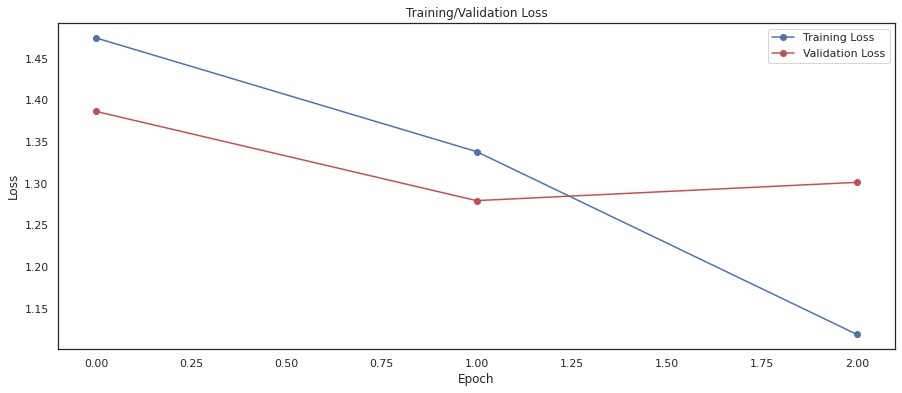

[2020-10-16 20:01:07,516][INFO] ## epoch: best, acc: 0.46500000, f1: 0.28756902, best_f1: 0.28756902



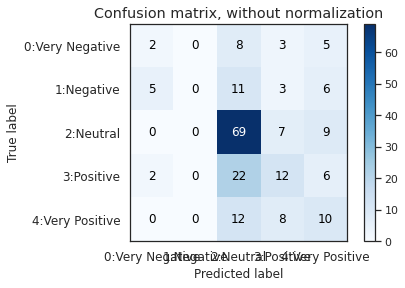

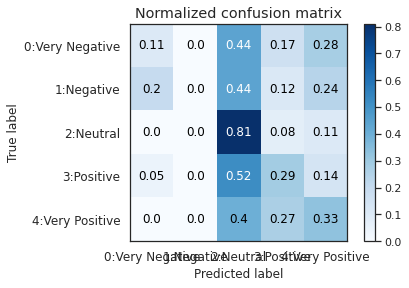

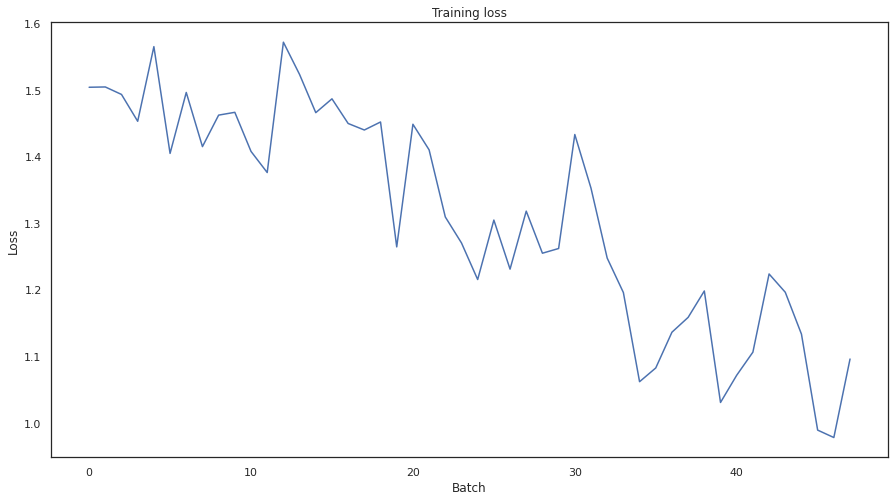

[2020-10-16 20:01:08,208][INFO] ## Process Time (sec): 25.884922945000085
[2020-10-16 20:01:08,212][INFO] ## Start training for 5000 samples


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

[2020-10-16 20:01:13,191][INFO] ## Total Training Steps: 237 (79 batches x 3 epochs)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2020-10-16 20:01:31,533][INFO] ## epoch: 1, train loss: 1.3914, valid loss: 1.2695
[2020-10-16 20:01:31,534][INFO] ## acc: 0.4605, f1: 0.2926, best_f1: 0.2926, last lr: 0.000015
[2020-10-16 20:01:49,840][INFO] ## epoch: 2, train loss: 1.1273, valid loss: 1.1748
[2020-10-16 20:01:49,840][INFO] ## acc: 0.5145, f1: 0.4226, best_f1: 0.4226, last lr: 0.000007
[2020-10-16 20:02:08,133][INFO] ## epoch: 3, train loss: 0.8595, valid loss: 1.2134
[2020-10-16 20:02:08,134][INFO] ## acc: 0.5355, f1: 0.4475, best_f1: 0.4475, last lr: 0.000000

[2020-10-16 20:02:08,198][INFO] ## ================ Training Completed: Starting Post Process ===============


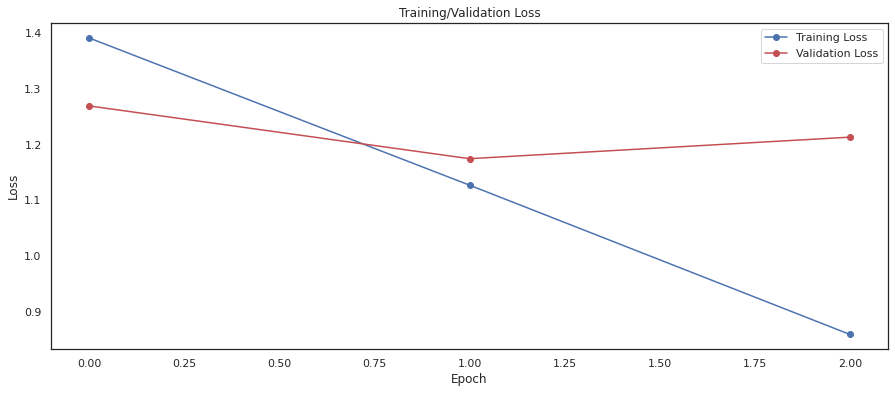

[2020-10-16 20:02:08,479][INFO] ## epoch: best, acc: 0.53546454, f1: 0.44752066, best_f1: 0.44752066



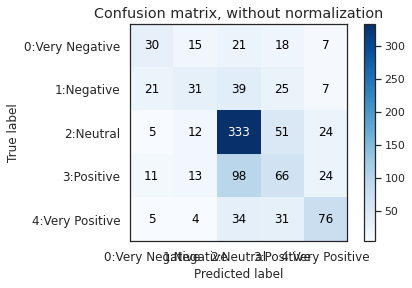

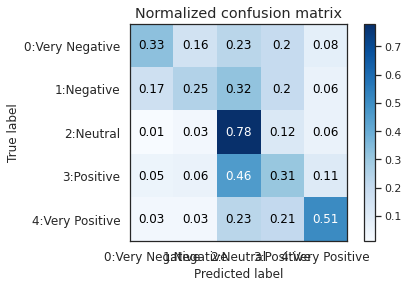

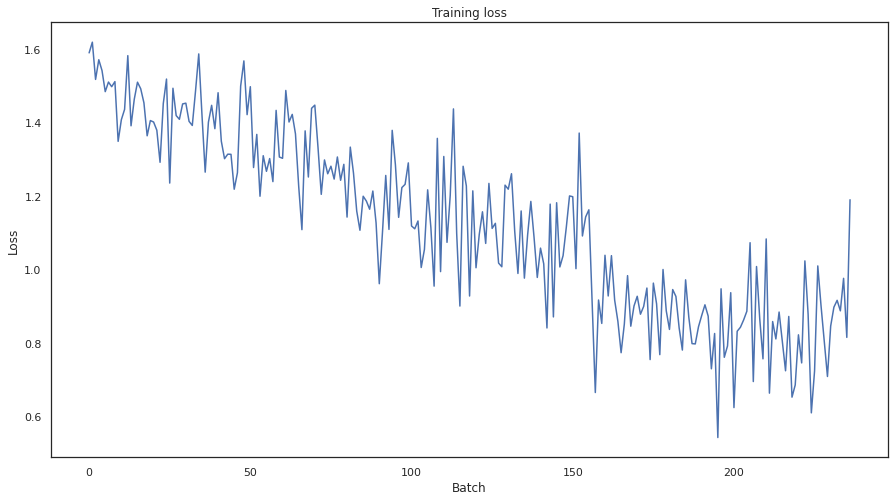

[2020-10-16 20:02:09,166][INFO] ## Process Time (sec): 56.133908066000004
[2020-10-16 20:02:09,170][INFO] ## Start training for 10000 samples


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

[2020-10-16 20:02:14,123][INFO] ## Total Training Steps: 471 (157 batches x 3 epochs)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2020-10-16 20:02:50,593][INFO] ## epoch: 1, train loss: 1.2647, valid loss: 0.9998
[2020-10-16 20:02:50,594][INFO] ## acc: 0.6247, f1: 0.5605, best_f1: 0.5605, last lr: 0.000015
[2020-10-16 20:03:26,994][INFO] ## epoch: 2, train loss: 0.8401, valid loss: 0.9364
[2020-10-16 20:03:26,995][INFO] ## acc: 0.6457, f1: 0.5978, best_f1: 0.5978, last lr: 0.000007
[2020-10-16 20:04:03,390][INFO] ## epoch: 3, train loss: 0.6222, valid loss: 0.9980
[2020-10-16 20:04:03,391][INFO] ## acc: 0.6482, f1: 0.6039, best_f1: 0.6039, last lr: 0.000000

[2020-10-16 20:04:03,443][INFO] ## ================ Training Completed: Starting Post Process ===============


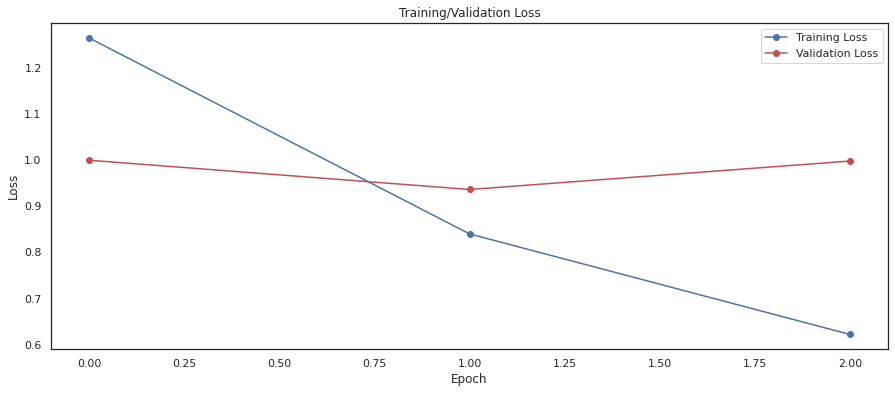

[2020-10-16 20:04:03,717][INFO] ## epoch: best, acc: 0.64817591, f1: 0.60387037, best_f1: 0.60387037



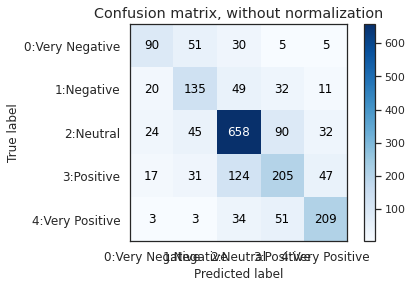

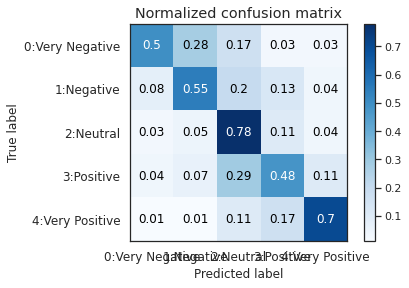

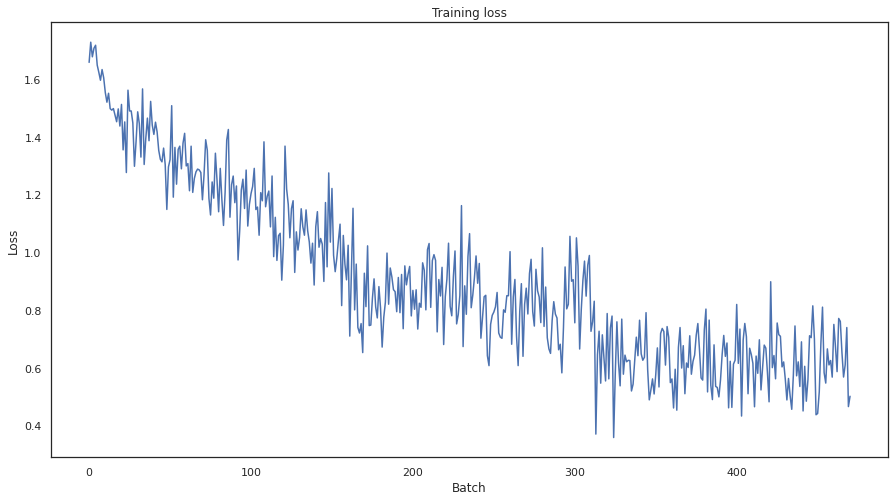

[2020-10-16 20:04:04,410][INFO] ## Process Time (sec): 110.48019083899999
[2020-10-16 20:04:04,416][INFO] ## Start training for 100000 samples


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

[2020-10-16 20:04:09,149][INFO] ## Total Training Steps: 4689 (1563 batches x 3 epochs)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2020-10-16 20:10:12,582][INFO] ## epoch: 1, train loss: 0.9228, valid loss: 0.7314
[2020-10-16 20:10:12,584][INFO] ## acc: 0.7262, f1: 0.6926, best_f1: 0.6926, last lr: 0.000015
[2020-10-16 20:16:16,811][INFO] ## epoch: 2, train loss: 0.6510, valid loss: 0.6827
[2020-10-16 20:16:16,812][INFO] ## acc: 0.7453, f1: 0.7223, best_f1: 0.7223, last lr: 0.000007
[2020-10-16 20:22:20,365][INFO] ## epoch: 3, train loss: 0.5621, valid loss: 0.6929
[2020-10-16 20:22:20,366][INFO] ## acc: 0.7441, f1: 0.7201, best_f1: 0.7223, last lr: 0.000000

[2020-10-16 20:22:20,420][INFO] ## ================ Training Completed: Starting Post Process ===============


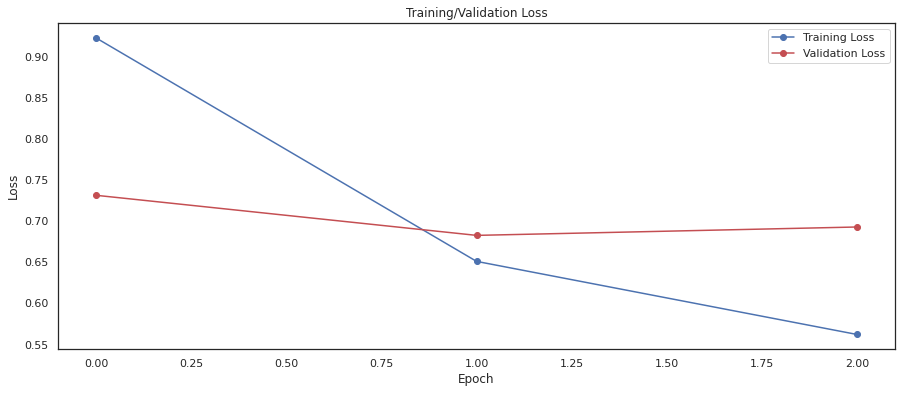

[2020-10-16 20:22:20,721][INFO] ## epoch: best, acc: 0.74530000, f1: 0.72225799, best_f1: 0.72225799



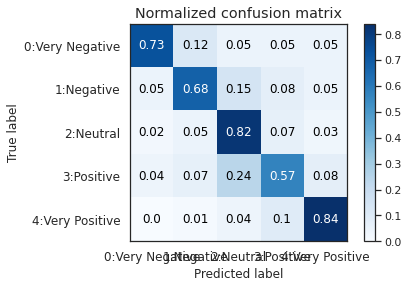

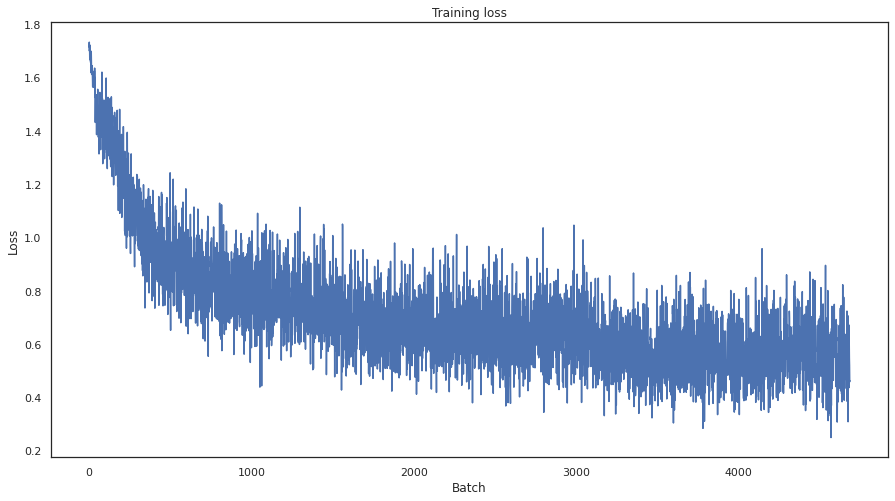

[2020-10-16 20:22:21,590][INFO] ## Process Time (sec): 1092.6756610520001
[2020-10-16 20:22:21,594][INFO] ## Start training for 500000 samples


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

[2020-10-16 20:22:27,305][INFO] ## Total Training Steps: 23439 (7813 batches x 3 epochs)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2020-10-16 20:52:41,697][INFO] ## epoch: 1, train loss: 0.7675, valid loss: 0.6111
[2020-10-16 20:52:41,699][INFO] ## acc: 0.7732, f1: 0.7513, best_f1: 0.7513, last lr: 0.000015
[2020-10-16 21:22:55,421][INFO] ## epoch: 2, train loss: 0.5740, valid loss: 0.5845
[2020-10-16 21:22:55,422][INFO] ## acc: 0.7859, f1: 0.7640, best_f1: 0.7640, last lr: 0.000007
[2020-10-16 21:53:08,237][INFO] ## epoch: 3, train loss: 0.5152, valid loss: 0.5776
[2020-10-16 21:53:08,238][INFO] ## acc: 0.7889, f1: 0.7693, best_f1: 0.7693, last lr: 0.000000

[2020-10-16 21:53:08,303][INFO] ## ================ Training Completed: Starting Post Process ===============


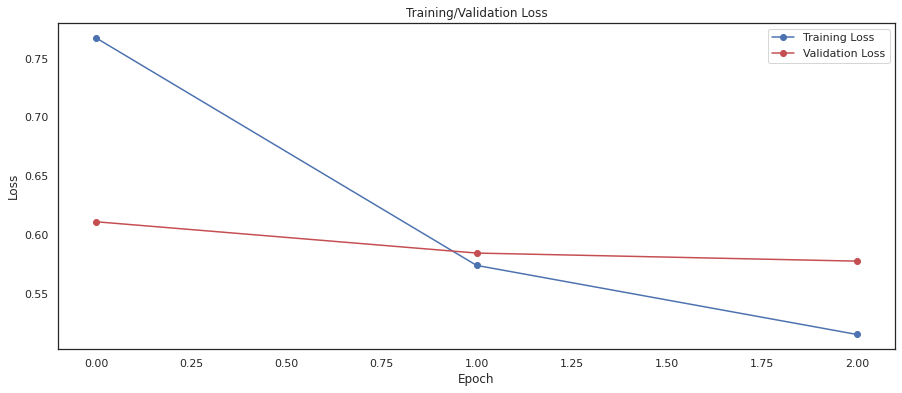

[2020-10-16 21:53:08,613][INFO] ## epoch: best, acc: 0.78887000, f1: 0.76931943, best_f1: 0.76931943



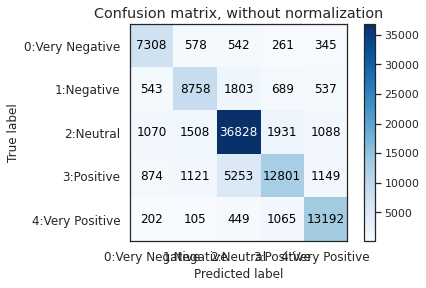

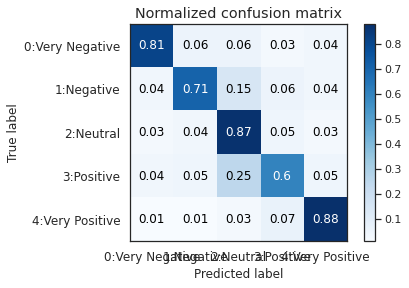

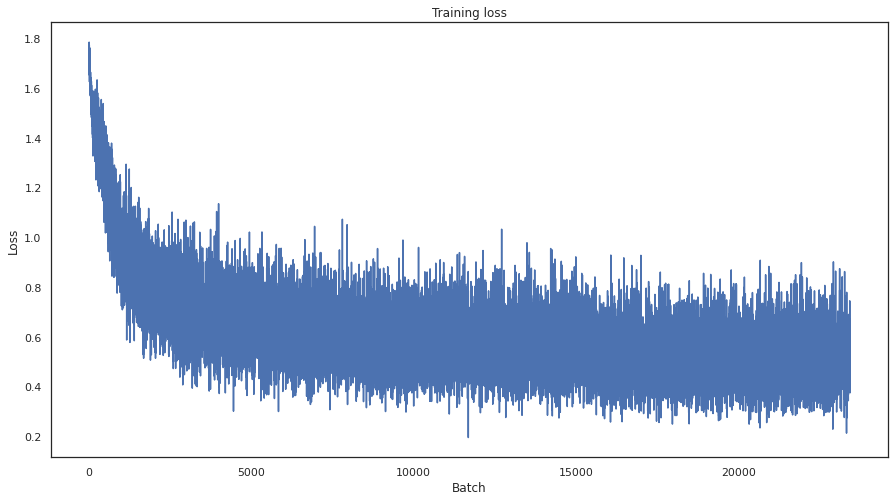

[2020-10-16 21:53:10,142][INFO] ## Process Time (sec): 5443.282805224


Accuracy      F1     Time
1000      0.465  0.2876  25.8849
5000     0.5355  0.4475  56.1339
10000    0.6482  0.6039   110.48
100000   0.7453  0.7223  1092.68
500000   0.7889  0.7693  5443.28

In [32]:
for n in n_trains:
    logger.info("Start training for %d samples" %n)

    # Stratified sampling
    train_size = n / len(X_all)
    test_size = train_size * 0.2    
    sss = StratifiedShuffleSplit(n_splits=1, train_size=train_size, test_size=test_size, random_state=rand_seed)
    for train_indices, test_indices in sss.split(X_all, y_all):
        # Filter 
        X_sampled_train = np.array(X_all, dtype=object)[train_indices]
        y_sampled_train = np.array(y_all)[train_indices]
        X_sampled_test = np.array(X_all, dtype=object)[test_indices]
        y_sampled_test = np.array(y_all)[test_indices]

        # Make sure to load the pre-trained model every time
        bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

        # Train the model for this fold
        start_time = time.perf_counter() # use time.process_time() for CPU time
        acc, f1, valid_best, model_trained = \
            train_transformer(bert_model, X_sampled_train, y_sampled_train, X_sampled_test, y_sampled_test, \
                              learning_rate, num_epochs, batch_size, patience, warm_up_proportion, max_grad_norm, max_seq_length)
        end_time = time.perf_counter() # use time.process_time() for CPU time
        duration = end_time - start_time
        logger.info("Process Time (sec): {}".format(duration))
        result_bert.loc[n] = (round(acc,4), round(f1,4), duration)
        
torch.save(model_trained.state_dict(), output_dir + "stocktwit_bert.dict")
result_bert

# Result

In [39]:
# If disconnected after the training complete, just recreate the result_df rather than running the training again...
disconnected = True
if disconnected:
    n_trains = [1000, 5000, 10000, 100000, 500000]
    result_lstm = pd.DataFrame(columns=['Accuracy', 'F1(macro)', 'Total_Time'], index=n_trains)
    result_lstm.loc[1000] = (0.4115,	0.1166,	4.02131)
    result_lstm.loc[5000] = (0.4969,	0.4542,	13.189)
    result_lstm.loc[10000] = (0.5514,	0.4988,	23.8845)
    result_lstm.loc[100000] = (0.6856,	0.6548,	273.114)
    result_lstm.loc[500000] = (0.7593,	0.7375,	2704.45)

result_lstm['ms/data'] = result_lstm['Total_Time'] / result_lstm.index * 1000
result_lstm

Accuracy F1(macro) Total_Time  ms/data
1000     0.4115    0.1166    4.02131  4.02131
5000     0.4969    0.4542     13.189   2.6378
10000    0.5514    0.4988    23.8845  2.38845
100000   0.6856    0.6548    273.114  2.73114
500000   0.7593    0.7375    2704.45   5.4089

In [37]:
# If disconnected after the training complete, just recreate the result_df rather than running the training again...
disconnected = True
if disconnected:
    n_trains = [1000, 5000, 10000, 100000, 500000]
    result_bert = pd.DataFrame(columns=['Accuracy', 'F1(macro)', 'Total_Time'], index=n_trains)
    result_bert.loc[1000] = (0.465,	0.2876,	25.8849)
    result_bert.loc[5000] = (0.5355,	0.4475,	56.1339)
    result_bert.loc[10000] = (0.6482,	0.6039,	110.48)
    result_bert.loc[100000] = (0.7453,	0.7223,	1092.68)
    result_bert.loc[500000] = (0.7889,	0.7693,	5443.28)

result_bert['ms/data'] = result_bert['Total_Time'] / result_bert.index * 1000
result_bert

Accuracy F1(macro) Total_Time  ms/data
1000      0.465    0.2876    25.8849  25.8849
5000     0.5355    0.4475    56.1339  11.2268
10000    0.6482    0.6039     110.48   11.048
100000   0.7453    0.7223    1092.68  10.9268
500000   0.7889    0.7693    5443.28  10.8866

[2020-10-17 07:47:01,817][INFO] ## Start training for 1000 samples


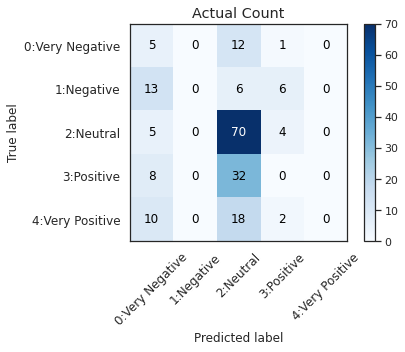

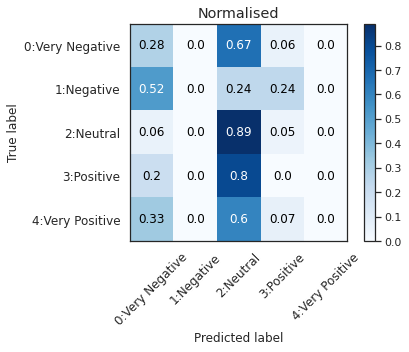

[2020-10-17 07:47:11,259][INFO] ## Epoch: 5, Steps: 16, Accuracy: 0.39062500, F1: 0.16293056



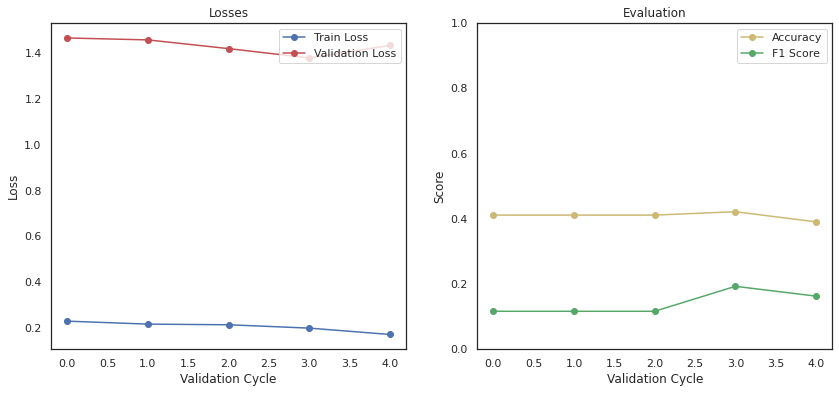

[2020-10-17 07:47:11,730][INFO] ## ##### Completed all epochs #####
[2020-10-17 07:47:11,733][INFO] ## Accuracy: 0.39062500, F1: 0.16293056
[2020-10-17 07:47:11,739][INFO] ## Process Time (sec): 7.894798159000857
[2020-10-17 07:47:11,741][INFO] ## Start training for 5000 samples


[2020-10-17 07:47:38,769][INFO] ## Epoch: 5, Steps: 79, Accuracy: 0.46770833, F1: 0.38957306



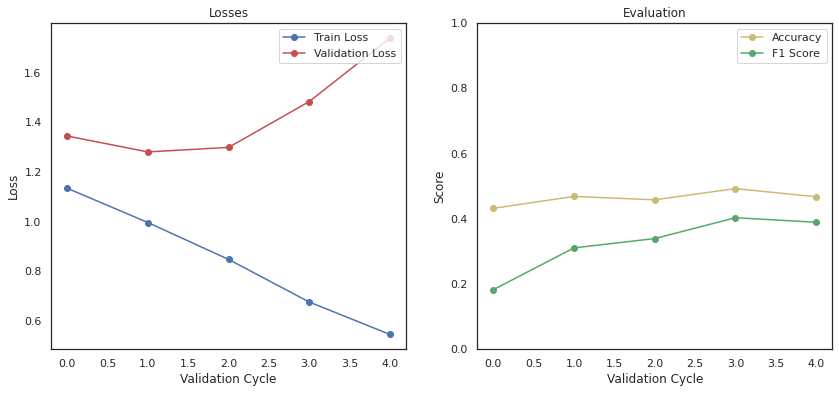

[2020-10-17 07:47:39,247][INFO] ## ##### Completed all epochs #####
[2020-10-17 07:47:39,248][INFO] ## Accuracy: 0.46770833, F1: 0.38957306
[2020-10-17 07:47:39,250][INFO] ## Process Time (sec): 25.531844903000092
[2020-10-17 07:47:39,252][INFO] ## Start training for 10000 samples


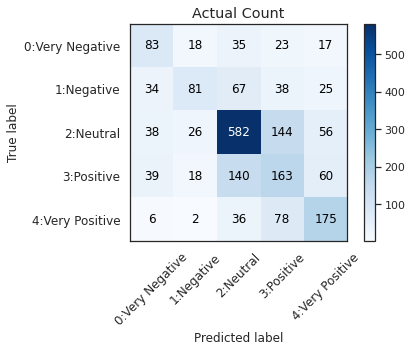

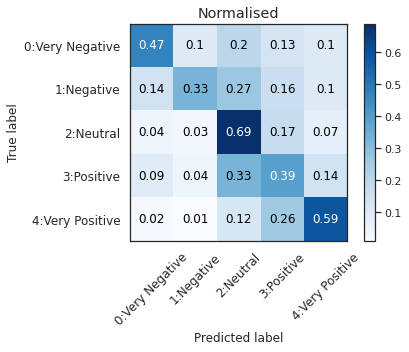

[2020-10-17 07:48:31,169][INFO] ## Epoch: 5, Steps: 157, Accuracy: 0.54637097, F1: 0.49423414



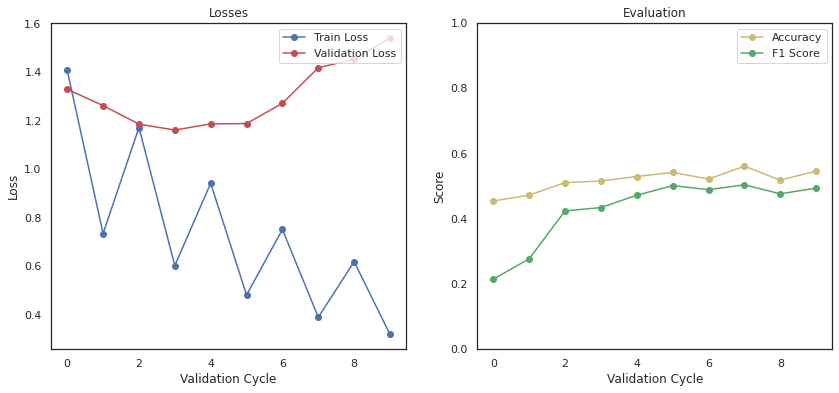

[2020-10-17 07:48:31,593][INFO] ## ##### Completed all epochs #####
[2020-10-17 07:48:31,594][INFO] ## Accuracy: 0.54637097, F1: 0.49423414
[2020-10-17 07:48:31,596][INFO] ## Process Time (sec): 50.362443679001444
[2020-10-17 07:48:31,598][INFO] ## Start training for 100000 samples


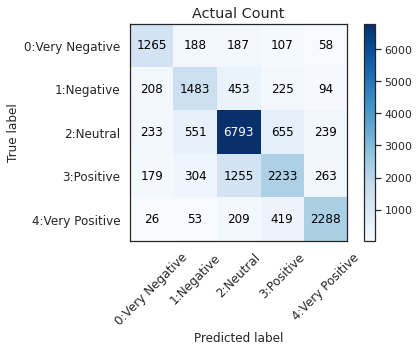

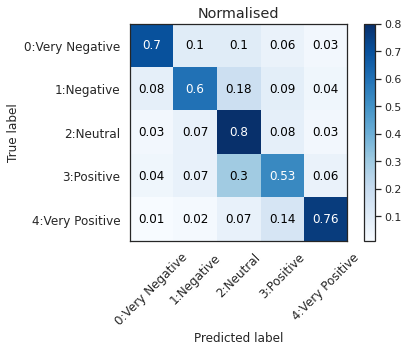

[2020-10-17 07:58:38,870][INFO] ## Epoch: 5, Steps: 1563, Accuracy: 0.70422676, F1: 0.67787125



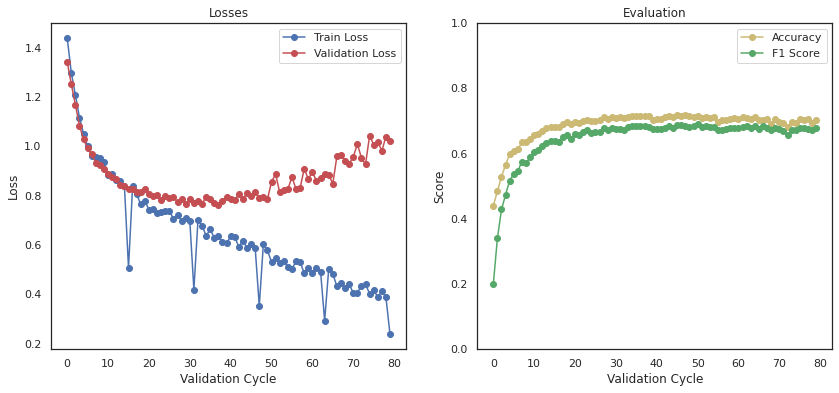

[2020-10-17 07:58:39,350][INFO] ## ##### Completed all epochs #####
[2020-10-17 07:58:39,351][INFO] ## Accuracy: 0.70422676, F1: 0.67787125
[2020-10-17 07:58:39,356][INFO] ## Process Time (sec): 605.7279750889993
[2020-10-17 07:58:39,361][INFO] ## Start training for 500000 samples


In [ ]:
# Run LSTM again with more cycles and more nodes as it's faster than fine-tuning BERT base model
epochs=5
patience=3
embed_size=1024
lstm_size=256
dense_size=256
lstm_layers=4
verbose=0

n_trains = [1000, 5000, 10000, 100000, 500000]
result_lstm_2 = pd.DataFrame(columns=['Accuracy', 'F1', 'Time'], index=n_trains)

for n in n_trains:
    logger.info("Start training for %d samples" %n)

    # Stratified sampling
    train_size = n / len(X_all)
    test_size = train_size * 0.2    
    sss = StratifiedShuffleSplit(n_splits=1, train_size=train_size, test_size=test_size, random_state=rand_seed)
    for train_indices, test_indices in sss.split(X_all, y_all):
        # Filter 
        X_sampled_train = np.array(X_all, dtype=object)[train_indices]
        y_sampled_train = np.array(y_all)[train_indices]
        X_sampled_test = np.array(X_all, dtype=object)[test_indices]
        y_sampled_test = np.array(y_all)[test_indices]

        # Set Model
        model = TextClassifier(len(vocab)+1, embed_size, lstm_size, dense_size, 5, lstm_layers, dropout)


        # Train the model for this fold
        start_time = time.perf_counter() # use time.process_time() for CPU time
        acc, f1 = train_lstm_model(model, X_sampled_train, y_sampled_train, X_sampled_test, y_sampled_test, \
                                epochs, batch_size, learning_rate, sequence_length, \
                                patience, clip, valid_every, verbose)
        end_time = time.perf_counter() # use time.process_time() for CPU time
        duration = end_time - start_time
        logger.info("Process Time (sec): {}".format(duration))
        result_lstm_2.loc[n] = (round(acc,4), round(f1,4), duration)
        
result_lstm_2

# Extra - tweet stream

In [40]:
with open(tweet_dir + 'test_twits.json', 'r') as f:
    test_data = json.load(f)

def twit_stream():
    for twit in test_data['data']:
        yield twit

next(twit_stream())

{'message_body': '$JWN has moved -1.69% on 10-31. Check out the movement and peers at  https://dividendbot.com?s=JWN',
 'timestamp': '2018-11-01T00:00:05Z'}

In [45]:
import torch.nn.functional as F

def predict(text, model, tokenizer):
    """ 
    Make a prediction on a single sentence.

    Parameters
    ----------
        text : The string to make a prediction on.
        model : The model to use for making the prediction.
        vocab : Dictionary for word to word ids. The key is the word and the value is the word id.

    Returns
    -------
        pred : Prediction vector
    """   
    text = preprocess(text)
    inputs = tokenizer(text, 
                   return_tensors="pt", 
                   padding='max_length',
                   max_length=96,
                   add_special_tokens=True,
                   truncation=True)

    outputs = model(**inputs)[0].detach()    
    pred = F.softmax(outputs, dim=1)
    
    return pred

In [43]:
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model.load_state_dict(torch.load(output_dir + 'stocktwit_bert.dict'))
model.eval()
model.to("cpu")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [46]:
# Check
text = "Google is working on self driving cars, I'm bullish on $goog"
predict(text, model, tokenizer)

tensor([[4.4908e-04, 1.9778e-02, 2.5711e-02, 8.6952e-01, 8.4539e-02]])

In [138]:
def score_twits(stream, model, tokenizer, universe):
    """ 
    Given a stream of twits and a universe of tickers, return sentiment scores for tickers in the universe.
    """
    class_names = ['0:Very Negative', '1:Negative', '2:Neutral', '3:Positive', '4:Very Positive']
    for twit in stream:

        # Get the message text
        text = twit['message_body']
        if len(tokenizer.tokenize(preprocess(text))) < 10:
            continue
        symbols = re.findall('\$[A-Z]{2,4}', text)
        score = predict(text, model, tokenizer)
        score = np.round(score.tolist(), 4).squeeze()
        prediction = class_names[np.argmax(score)] + " {:.1f}%".format(np.max(score)*100)

        for symbol in symbols:
            if symbol in universe:
                yield {'symbol': symbol, 'pred': prediction, 'score': score, 'text': text, 'timestamp': twit['timestamp']}

In [139]:
# Select Universe
universe = {'$BBRY', '$AAPL', '$AMZN', '$BABA', '$YHOO', '$LQMT', '$FB', '$GOOG', '$BBBY', '$JNUG', '$SBUX', '$MU'}
score_stream = score_twits(twit_stream(), model, tokenizer, universe)

In [140]:
# Process
for i in range(10):
    print(next(score_stream))
    i+=1

{'symbol': '$AMZN', 'pred': '3:Positive 99.7%', 'score': array([1.000e-04, 7.000e-04, 8.000e-04, 9.966e-01, 1.800e-03]), 'text': '$AMZN A lot of technical signs point to a short-term bottom in place for stocks (John Murphy)', 'timestamp': '2018-11-01T00:00:42Z'}
{'symbol': '$MU', 'pred': '2:Neutral 72.7%', 'score': array([0.0022, 0.0908, 0.7266, 0.1785, 0.0019]), 'text': '@TraderLeibniz $NVDA Perhaps, no chance for $MU and $AMD till cycle &amp; trade war no longer concerns.... played these names for years. GL', 'timestamp': '2018-11-01T00:04:21Z'}
{'symbol': '$AAPL', 'pred': '2:Neutral 68.7%', 'score': array([0.0015, 0.0521, 0.6865, 0.257 , 0.003 ]), 'text': 'Bears tomorrow when $AAPL reports earnings and the rest of the market rips higher. $AMZN $SQ $IBM $IEP $AVGO $MSFT $TSLA $NFLX $GOOG $DIA', 'timestamp': '2018-11-01T00:07:32Z'}
{'symbol': '$AMZN', 'pred': '2:Neutral 68.7%', 'score': array([0.0015, 0.0521, 0.6865, 0.257 , 0.003 ]), 'text': 'Bears tomorrow when $AAPL reports earning